In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import spaces


class Notreal(gym.Env):
    """ will remove the stoichastic part of the system """
    def __init__(self,render_mode="human"):
        super(Notreal, self).__init__()
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=np.inf , shape=(3,), dtype=np.float16)
        
        # Actions are [u1, u2], both in some control range
        
 # Actions are [I, Fn] - Light Intensity and Inflow Rate
        self.action_space = spaces.Box(low=np.array([120, 0]), high=np.array([400, 40]), dtype=np.float16)
        
                
        
        self.render_mode="human"
        # Time step for numerical integration
        self.dt = 0.1
        
        self.state = np.array([1 , 150 , 0])
        self.um= .0572
        self.ud=0.001
        self.Kn= 393.1
        self.Ynx=504.1
        self.km=.000016
        self.kd=0.281
        self.ks=178.9
        self.ki=447.1
        self.ksq=23.51
        self.kiq=800
        self.Knp=16.89
        
        #the manipulated variables are light intelfnsity I and inflow rate Fn
        
        #values for normalizatrion
        # self.action_low = np.array([0, 0])
        # self.action_high = np.array([400, 40])
        
        
        # self.max_CX=1000
        # self.max_CN=10000
        # self.max_CQ=100
        
        self.max_episodes=1000
        self.cureent_episode=0        
        
        
        
    # def denormalize_action(self, action) -> np.ndarray:
    #     """ Convert the normalized action [-1, 1] to the original scale [0, 400] and [0, 40] """
        
    #     return 0.5 * (action + 1) * (self.action_high - self.action_low) + self.action_low

            
        
    # def normalize_state(self, state) -> np.ndarray:
    #     """ Convert the state to a normalized form """
    #     return state / np.array([self.max_CX, self.max_CN, self.max_CQ])
        
    # def dernomalize_state(self, state) -> np.ndarray:
    #     """ Convert the state to a normalized form """
    #     return state * np.array([self.max_CX, self.max_CN, self.max_CQ])
                
        
        
        
    def reset(self, seed=None, options=None):
        # Reset the state to initial values
       # self.state = self.normalize_state(np.array([1, 150, 0]))
        self.state = np.array([1 , 150 , 0])
        self.cureent_episode = 0
        self.REWARD=0

        # Return the observation and an empty info dictionary
        return self.state  , {}
        
        #change self. state ?

    


    def step(self, action):
        if not isinstance(action, (list, np.ndarray)) or len(action) != 2:
            print(action)
            raise ValueError("Action should be a list or array with exactly 2 values, [L, Fn]")
        #L, Fn =  self.denormalize_action(action)
        #print(action)
        # L=130
        # Fn=0
        
        
        L,Fn =  action

        cx,cn,cq =  self.state
        
        dt = self.dt
        u_m=self.um
        k_s=self.ks 
        K_N=self.Kn
        k_i=self.ki
        x=cx
        n=cn 
        u_d=self.ud
        Y_nx=self.Ynx
        k_m=self.km
        k_sq=self.ksq
        k_iq=self.kiq
        k_d=self.kd
        q=cq
        K_Np=self.Knp


        
                

        dx   = u_m * L/(L+k_s+((L**2)/k_i)) * x * (n/(n+K_N)) - u_d*x
        dn   = - Y_nx*u_m* (L/(L+k_s+(L**2)/k_i)) * x * (n/(n+K_N))+ Fn
        if n<500 and x > 10:
            dq   = (k_m * L/(L+k_sq+L**2./k_iq) * x - k_d * q/(n+K_Np))
        else:
            dq=0
        # Update states
        
        cx+=(dx * dt)
        cn+=(dn * dt)
        cq+=(dq * dt)
        
        
                
        #so what is the sign function ? 
        
        # Ensure non-negative concentrations
        #y1 = max(0, y1)
        #y2 = max(0, y2)
        
        self.state =(np.array([cx,cn,cq]))
        
        # Reward is based on maximizing y2
        reward = cq *10 if cq >  0 else 0
        
        
        
        # Done if the system has run too long or if values go out of bounds
        done = False
        
       #changing the negative reward (Reducing it ) 
        if cn<0  or cx < 0 or cq < 0 :
            reward = -10  #changeing the reward to -1 from -1000
            done = True
        
        self.cureent_episode+=1
        if self.cureent_episode>=self.max_episodes:
            done = True
            
        #this is extra for the PPO case, im adding a negative reward at the end if Cq is 0 
         
        if self.cureent_episode>=self.max_episodes -1 :
            done = True
            if cq==0:
                reward=-10
        
        
        self.REWARD+=reward
        
        return self.state, reward, done,False, {}
    

        # Optional rendering for visualization, not essential
    def render(self):
        if self.render_mode == "human":
            print(f"Current state: {self.dernomalize_state(self.state) } Total_Reward={self.REWARD} ")
            return(str("Current state: {self.dernomalize_state(self.state) } Total_Reward={self.REWARD})" ))
            # You can add more sophisticated rendering here, such as creating a graphical window.
        elif self.render_mode == "rgb_array":
            # Return an RGB array representation if needed for video recording or display
            pass
        elif self.render_mode == "ansi":
            return str(self.state)  # For text-based environments
        
        
enviorment=Notreal()
enviorment.reset()
done=False
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Wrap your environment in DummyVecEnv
env = DummyVecEnv([lambda: enviorment])
# Now apply VecNormalize to normalize observations and rewards
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)


In [4]:
from stable_baselines3 import PPO
modelPPO=PPO("MlpPolicy", env, verbose=1)


Using cpu device


In [52]:
modelPPO.learn(total_timesteps=1000000,progress_bar=True)

Output()

-----------------------------
| time/              |      |
|    fps             | 1523 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 1069         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0008657792 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.75        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0682       |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00066     |
|    std                  | 1.58         |
|    value_loss           | 0.184        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 782         |
|    iterations           | 3           |
|    time_elapsed         | 7           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.003981557 |
|    clip_fraction        | 0.0205      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.76       |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.192       |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.000676   |
|    std                  | 1.6         |
|    value_loss           | 0.346       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 722          |
|    iterations           | 4            |
|    time_elapsed         | 11           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0044928184 |
|    clip_fraction        | 0.0543       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.79        |
|    explained_variance   | 0.911        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.005       |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.0044      |
|    std                  | 1.62         |
|    value_loss           | 0.165        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 698          |
|    iterations           | 5            |
|    time_elapsed         | 14           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0054325117 |
|    clip_fraction        | 0.0371       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.81        |
|    explained_variance   | 0.841        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0247       |
|    n_updates            | 570          |
|    policy_gradient_loss | -0.0017      |
|    std                  | 1.64         |
|    value_loss           | 0.182        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6           |
|    time_elapsed         | 17          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.004117712 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.84       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.182       |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00481    |
|    std                  | 1.66        |
|    value_loss           | 0.147       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 7            |
|    time_elapsed         | 21           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0043103076 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.86        |
|    explained_variance   | 0.859        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00597      |
|    n_updates            | 590          |
|    policy_gradient_loss | 0.000355     |
|    std                  | 1.69         |
|    value_loss           | 0.136        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 681          |
|    iterations           | 8            |
|    time_elapsed         | 24           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0030690937 |
|    clip_fraction        | 0.0262       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.88        |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0148      |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00308     |
|    std                  | 1.7          |
|    value_loss           | 0.0773       |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 9          |
|    time_elapsed         | 27         |
|    total_timesteps      | 18432      |
| train/                  |            |
|    approx_kl            | 0.00725702 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.9       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00498   |
|    n_updates            | 610        |
|    policy_gradient_loss | -0.00911   |
|    std                  | 1.71       |
|    value_loss           | 0.00918    |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 10           |
|    time_elapsed         | 29           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0055558123 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.92        |
|    explained_variance   | 0.951        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0171      |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.00403     |
|    std                  | 1.75         |
|    value_loss           | 0.0572       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 690          |
|    iterations           | 11           |
|    time_elapsed         | 32           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0027327687 |
|    clip_fraction        | 0.0178       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.94        |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0687       |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.000483    |
|    std                  | 1.75         |
|    value_loss           | 0.0857       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 12           |
|    time_elapsed         | 35           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0074656648 |
|    clip_fraction        | 0.0763       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.96        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0186      |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00693     |
|    std                  | 1.79         |
|    value_loss           | 0.0105       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 696          |
|    iterations           | 13           |
|    time_elapsed         | 38           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0064223576 |
|    clip_fraction        | 0.065        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4           |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.136        |
|    n_updates            | 650          |
|    policy_gradient_loss | -0.00584     |
|    std                  | 1.82         |
|    value_loss           | 0.0776       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 14          |
|    time_elapsed         | 41          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.005152085 |
|    clip_fraction        | 0.0466      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.02       |
|    explained_variance   | 0.724       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0136      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.00027    |
|    std                  | 1.82        |
|    value_loss           | 0.16        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 698          |
|    iterations           | 15           |
|    time_elapsed         | 43           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0055432254 |
|    clip_fraction        | 0.0523       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.04        |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0281       |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00326     |
|    std                  | 1.85         |
|    value_loss           | 0.0657       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 16          |
|    time_elapsed         | 46          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.005115262 |
|    clip_fraction        | 0.0268      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.07       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00161    |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00194    |
|    std                  | 1.87        |
|    value_loss           | 0.136       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 706          |
|    iterations           | 17           |
|    time_elapsed         | 49           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0061091427 |
|    clip_fraction        | 0.048        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.1         |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0262       |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.00284     |
|    std                  | 1.9          |
|    value_loss           | 0.026        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 710          |
|    iterations           | 18           |
|    time_elapsed         | 51           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0049015502 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0611       |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00367     |
|    std                  | 1.92         |
|    value_loss           | 0.0973       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 19           |
|    time_elapsed         | 54           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0050239065 |
|    clip_fraction        | 0.0501       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00736      |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.007       |
|    std                  | 1.97         |
|    value_loss           | 0.0144       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 715          |
|    iterations           | 20           |
|    time_elapsed         | 57           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0040406073 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.18        |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.033       |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00465     |
|    std                  | 1.97         |
|    value_loss           | 0.0423       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 716          |
|    iterations           | 21           |
|    time_elapsed         | 60           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0019183683 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00397      |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.000718    |
|    std                  | 1.99         |
|    value_loss           | 0.207        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 715          |
|    iterations           | 22           |
|    time_elapsed         | 62           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0046800673 |
|    clip_fraction        | 0.0474       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.22        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00287      |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00311     |
|    std                  | 2.04         |
|    value_loss           | 0.0614       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 707         |
|    iterations           | 23          |
|    time_elapsed         | 66          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.006599898 |
|    clip_fraction        | 0.0717      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00928    |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.011      |
|    std                  | 2.08        |
|    value_loss           | 0.0371      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 24          |
|    time_elapsed         | 70          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.004428852 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0126      |
|    n_updates            | 760         |
|    policy_gradient_loss | -0.00162    |
|    std                  | 2.09        |
|    value_loss           | 0.0936      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 25           |
|    time_elapsed         | 73           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0048263534 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0027      |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00183     |
|    std                  | 2.1          |
|    value_loss           | 0.0777       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 696          |
|    iterations           | 26           |
|    time_elapsed         | 76           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0027568857 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0613       |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.000934    |
|    std                  | 2.1          |
|    value_loss           | 0.06         |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 27         |
|    time_elapsed         | 78         |
|    total_timesteps      | 55296      |
| train/                  |            |
|    approx_kl            | 0.00465852 |
|    clip_fraction        | 0.0346     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.3       |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0122    |
|    n_updates            | 790        |
|    policy_gradient_loss | -0.00179   |
|    std                  | 2.1        |
|    value_loss           | 0.0428     |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 709          |
|    iterations           | 28           |
|    time_elapsed         | 80           |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0052642375 |
|    clip_fraction        | 0.0424       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0688       |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.00327     |
|    std                  | 2.15         |
|    value_loss           | 0.131        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 714          |
|    iterations           | 29           |
|    time_elapsed         | 83           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0028426244 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.36        |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0402       |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.00304     |
|    std                  | 2.18         |
|    value_loss           | 0.0629       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 718          |
|    iterations           | 30           |
|    time_elapsed         | 85           |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0022416725 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.38        |
|    explained_variance   | 0.498        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00466     |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00156     |
|    std                  | 2.2          |
|    value_loss           | 0.21         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 721          |
|    iterations           | 31           |
|    time_elapsed         | 87           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0056108087 |
|    clip_fraction        | 0.0548       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.4         |
|    explained_variance   | 0.812        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00126      |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.00417     |
|    std                  | 2.24         |
|    value_loss           | 0.0882       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 723         |
|    iterations           | 32          |
|    time_elapsed         | 90          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.003474567 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.42       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0222      |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.00275    |
|    std                  | 2.24        |
|    value_loss           | 0.0194      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 724          |
|    iterations           | 33           |
|    time_elapsed         | 93           |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0036094063 |
|    clip_fraction        | 0.0317       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.42        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0271       |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.00122     |
|    std                  | 2.24         |
|    value_loss           | 0.0785       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 724          |
|    iterations           | 34           |
|    time_elapsed         | 96           |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0032938037 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.41        |
|    explained_variance   | 0.899        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.099        |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.00215     |
|    std                  | 2.22         |
|    value_loss           | 0.188        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 726          |
|    iterations           | 35           |
|    time_elapsed         | 98           |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0034360248 |
|    clip_fraction        | 0.0397       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.41        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00132     |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00258     |
|    std                  | 2.23         |
|    value_loss           | 0.0249       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 727          |
|    iterations           | 36           |
|    time_elapsed         | 101          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0058500622 |
|    clip_fraction        | 0.0641       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.43        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0325       |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.00511     |
|    std                  | 2.26         |
|    value_loss           | 0.0398       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 729          |
|    iterations           | 37           |
|    time_elapsed         | 103          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0045337295 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.44        |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00401     |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.00206     |
|    std                  | 2.26         |
|    value_loss           | 0.102        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 731          |
|    iterations           | 38           |
|    time_elapsed         | 106          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0031111378 |
|    clip_fraction        | 0.0315       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.43        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0203       |
|    n_updates            | 900          |
|    policy_gradient_loss | -0.00466     |
|    std                  | 2.24         |
|    value_loss           | 0.0341       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 733         |
|    iterations           | 39          |
|    time_elapsed         | 108         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.003405062 |
|    clip_fraction        | 0.0304      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.43       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0118     |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00215    |
|    std                  | 2.23        |
|    value_loss           | 0.0908      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 734          |
|    iterations           | 40           |
|    time_elapsed         | 111          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0047595864 |
|    clip_fraction        | 0.0257       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.42        |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.125        |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.000706    |
|    std                  | 2.23         |
|    value_loss           | 0.199        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 737          |
|    iterations           | 41           |
|    time_elapsed         | 113          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0044020093 |
|    clip_fraction        | 0.0444       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.41        |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0315       |
|    n_updates            | 930          |
|    policy_gradient_loss | -0.00356     |
|    std                  | 2.22         |
|    value_loss           | 0.0932       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 738          |
|    iterations           | 42           |
|    time_elapsed         | 116          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0048027486 |
|    clip_fraction        | 0.0546       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.41        |
|    explained_variance   | 0.916        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.163        |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.00273     |
|    std                  | 2.23         |
|    value_loss           | 0.106        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 739         |
|    iterations           | 43          |
|    time_elapsed         | 119         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.003954648 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.44       |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00675     |
|    n_updates            | 950         |
|    policy_gradient_loss | -0.00197    |
|    std                  | 2.27        |
|    value_loss           | 0.0926      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 739          |
|    iterations           | 44           |
|    time_elapsed         | 121          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0026558205 |
|    clip_fraction        | 0.0436       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.46        |
|    explained_variance   | 0.809        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0991       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.00161     |
|    std                  | 2.28         |
|    value_loss           | 0.253        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 740          |
|    iterations           | 45           |
|    time_elapsed         | 124          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0044488334 |
|    clip_fraction        | 0.0559       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.45        |
|    explained_variance   | 0.693        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0153       |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.000957    |
|    std                  | 2.26         |
|    value_loss           | 0.333        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 46          |
|    time_elapsed         | 127         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.004872716 |
|    clip_fraction        | 0.0443      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.43       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0205      |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.00273    |
|    std                  | 2.22        |
|    value_loss           | 0.0703      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 742         |
|    iterations           | 47          |
|    time_elapsed         | 129         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.007194507 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.42       |
|    explained_variance   | 0.874       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0431      |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.00275    |
|    std                  | 2.22        |
|    value_loss           | 0.35        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 744          |
|    iterations           | 48           |
|    time_elapsed         | 132          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0038149743 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.41        |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.378        |
|    n_updates            | 1000         |
|    policy_gradient_loss | 0.000193     |
|    std                  | 2.21         |
|    value_loss           | 0.455        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 746          |
|    iterations           | 49           |
|    time_elapsed         | 134          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0037858267 |
|    clip_fraction        | 0.0512       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.4         |
|    explained_variance   | 0.686        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.13         |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.00139     |
|    std                  | 2.19         |
|    value_loss           | 0.44         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 747          |
|    iterations           | 50           |
|    time_elapsed         | 137          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0008490292 |
|    clip_fraction        | 0.0578       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.4         |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.137        |
|    n_updates            | 1020         |
|    policy_gradient_loss | -0.00055     |
|    std                  | 2.22         |
|    value_loss           | 0.386        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 749          |
|    iterations           | 51           |
|    time_elapsed         | 139          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0016097242 |
|    clip_fraction        | 0.0313       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.42        |
|    explained_variance   | 0.662        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0152       |
|    n_updates            | 1030         |
|    policy_gradient_loss | 0.000261     |
|    std                  | 2.23         |
|    value_loss           | 0.367        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 752          |
|    iterations           | 52           |
|    time_elapsed         | 141          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0045711147 |
|    clip_fraction        | 0.0602       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.43        |
|    explained_variance   | 0.743        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0651       |
|    n_updates            | 1040         |
|    policy_gradient_loss | -0.000491    |
|    std                  | 2.24         |
|    value_loss           | 0.333        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 53           |
|    time_elapsed         | 143          |
|    total_timesteps      | 108544       |
| train/                  |              |
|    approx_kl            | 0.0020008385 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.44        |
|    explained_variance   | 0.872        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.166        |
|    n_updates            | 1050         |
|    policy_gradient_loss | 0.000544     |
|    std                  | 2.26         |
|    value_loss           | 0.23         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 756         |
|    iterations           | 54          |
|    time_elapsed         | 146         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.004702503 |
|    clip_fraction        | 0.0321      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.47       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0254     |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00201    |
|    std                  | 2.3         |
|    value_loss           | 0.0706      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 758         |
|    iterations           | 55          |
|    time_elapsed         | 148         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.007044195 |
|    clip_fraction        | 0.0282      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.5        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0359      |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.00181    |
|    std                  | 2.34        |
|    value_loss           | 0.0814      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 760         |
|    iterations           | 56          |
|    time_elapsed         | 150         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.006108282 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.53       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.129       |
|    n_updates            | 1080        |
|    policy_gradient_loss | -0.00218    |
|    std                  | 2.37        |
|    value_loss           | 0.106       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 762          |
|    iterations           | 57           |
|    time_elapsed         | 153          |
|    total_timesteps      | 116736       |
| train/                  |              |
|    approx_kl            | 0.0037876326 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.55        |
|    explained_variance   | 0.555        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0148       |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.00178     |
|    std                  | 2.4          |
|    value_loss           | 0.386        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 763          |
|    iterations           | 58           |
|    time_elapsed         | 155          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0069891526 |
|    clip_fraction        | 0.0659       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.57        |
|    explained_variance   | 0.483        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0532       |
|    n_updates            | 1100         |
|    policy_gradient_loss | -0.00265     |
|    std                  | 2.41         |
|    value_loss           | 0.152        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 764          |
|    iterations           | 59           |
|    time_elapsed         | 157          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0020206925 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.57        |
|    explained_variance   | 0.899        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.199        |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.000104    |
|    std                  | 2.41         |
|    value_loss           | 0.154        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 766         |
|    iterations           | 60          |
|    time_elapsed         | 160         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.004016781 |
|    clip_fraction        | 0.0222      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.58       |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0834      |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.000559   |
|    std                  | 2.43        |
|    value_loss           | 0.22        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 767          |
|    iterations           | 61           |
|    time_elapsed         | 162          |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0041469405 |
|    clip_fraction        | 0.0404       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.59        |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0641       |
|    n_updates            | 1130         |
|    policy_gradient_loss | -0.00304     |
|    std                  | 2.43         |
|    value_loss           | 0.0629       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 769          |
|    iterations           | 62           |
|    time_elapsed         | 165          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0033903234 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.59        |
|    explained_variance   | 0.927        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0164       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.00336     |
|    std                  | 2.42         |
|    value_loss           | 0.12         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 770          |
|    iterations           | 63           |
|    time_elapsed         | 167          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 0.0037546083 |
|    clip_fraction        | 0.038        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.58        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00467     |
|    n_updates            | 1150         |
|    policy_gradient_loss | -0.00543     |
|    std                  | 2.41         |
|    value_loss           | 0.0274       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 772         |
|    iterations           | 64          |
|    time_elapsed         | 169         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.005059003 |
|    clip_fraction        | 0.0471      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.58       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0152      |
|    n_updates            | 1160        |
|    policy_gradient_loss | -0.00303    |
|    std                  | 2.42        |
|    value_loss           | 0.0186      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 773         |
|    iterations           | 65          |
|    time_elapsed         | 172         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.008151275 |
|    clip_fraction        | 0.0718      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.6        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00175     |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.00828    |
|    std                  | 2.45        |
|    value_loss           | 0.0466      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 774          |
|    iterations           | 66           |
|    time_elapsed         | 174          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0028186287 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.6         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0211       |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00115     |
|    std                  | 2.45         |
|    value_loss           | 0.0155       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 775         |
|    iterations           | 67          |
|    time_elapsed         | 176         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.002762738 |
|    clip_fraction        | 0.00923     |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.6        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0081      |
|    n_updates            | 1190        |
|    policy_gradient_loss | -0.000852   |
|    std                  | 2.44        |
|    value_loss           | 0.0359      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 777          |
|    iterations           | 68           |
|    time_elapsed         | 179          |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0030056848 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.6         |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00146     |
|    n_updates            | 1200         |
|    policy_gradient_loss | -0.00124     |
|    std                  | 2.45         |
|    value_loss           | 0.0273       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 778          |
|    iterations           | 69           |
|    time_elapsed         | 181          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0023195331 |
|    clip_fraction        | 0.0356       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.61        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.002        |
|    n_updates            | 1210         |
|    policy_gradient_loss | -0.00219     |
|    std                  | 2.45         |
|    value_loss           | 0.0163       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 779          |
|    iterations           | 70           |
|    time_elapsed         | 183          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0041225934 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.6         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00355      |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.00186     |
|    std                  | 2.44         |
|    value_loss           | 0.0201       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 780         |
|    iterations           | 71          |
|    time_elapsed         | 186         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.007202162 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.58       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00275    |
|    n_updates            | 1230        |
|    policy_gradient_loss | -0.00397    |
|    std                  | 2.42        |
|    value_loss           | 0.0282      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 781          |
|    iterations           | 72           |
|    time_elapsed         | 188          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0022929206 |
|    clip_fraction        | 0.0324       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.57        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00504      |
|    n_updates            | 1240         |
|    policy_gradient_loss | -0.00132     |
|    std                  | 2.41         |
|    value_loss           | 0.0511       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 782          |
|    iterations           | 73           |
|    time_elapsed         | 191          |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 0.0061160293 |
|    clip_fraction        | 0.0523       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.57        |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0076       |
|    n_updates            | 1250         |
|    policy_gradient_loss | -0.00352     |
|    std                  | 2.4          |
|    value_loss           | 0.00993      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 783         |
|    iterations           | 74          |
|    time_elapsed         | 193         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.007357353 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.54       |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0135      |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.00205    |
|    std                  | 2.35        |
|    value_loss           | 0.0764      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 784         |
|    iterations           | 75          |
|    time_elapsed         | 195         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.004986372 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.54       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0178     |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00376    |
|    std                  | 2.37        |
|    value_loss           | 0.0213      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 785         |
|    iterations           | 76          |
|    time_elapsed         | 198         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.011166175 |
|    clip_fraction        | 0.0735      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.52       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00522    |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.00423    |
|    std                  | 2.32        |
|    value_loss           | 0.0186      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 786         |
|    iterations           | 77          |
|    time_elapsed         | 200         |
|    total_timesteps      | 157696      |
| train/                  |             |
|    approx_kl            | 0.004631245 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.5        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00243    |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.00203    |
|    std                  | 2.33        |
|    value_loss           | 0.0284      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 787          |
|    iterations           | 78           |
|    time_elapsed         | 202          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0053943796 |
|    clip_fraction        | 0.0655       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.5         |
|    explained_variance   | 0.993        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00093      |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.00267     |
|    std                  | 2.32         |
|    value_loss           | 0.00857      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 788          |
|    iterations           | 79           |
|    time_elapsed         | 205          |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0055152923 |
|    clip_fraction        | 0.048        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.48        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0276       |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.00486     |
|    std                  | 2.28         |
|    value_loss           | 0.0342       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 80          |
|    time_elapsed         | 207         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.004387983 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.45       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0294      |
|    n_updates            | 1320        |
|    policy_gradient_loss | -0.00252    |
|    std                  | 2.26        |
|    value_loss           | 0.0135      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 81           |
|    time_elapsed         | 209          |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0051177116 |
|    clip_fraction        | 0.0403       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.41        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0146      |
|    n_updates            | 1330         |
|    policy_gradient_loss | -0.00353     |
|    std                  | 2.21         |
|    value_loss           | 0.0181       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 791          |
|    iterations           | 82           |
|    time_elapsed         | 212          |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0098710675 |
|    clip_fraction        | 0.0704       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.38        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00744     |
|    n_updates            | 1340         |
|    policy_gradient_loss | -0.00336     |
|    std                  | 2.2          |
|    value_loss           | 0.00769      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 792         |
|    iterations           | 83          |
|    time_elapsed         | 214         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.005232942 |
|    clip_fraction        | 0.0498      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.36       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0024     |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.00384    |
|    std                  | 2.17        |
|    value_loss           | 0.00451     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 793         |
|    iterations           | 84          |
|    time_elapsed         | 216         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.007864137 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00721     |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.00483    |
|    std                  | 2.14        |
|    value_loss           | 0.00636     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 794         |
|    iterations           | 85          |
|    time_elapsed         | 219         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.008145295 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00466    |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.00569    |
|    std                  | 2.1         |
|    value_loss           | 0.00479     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 86          |
|    time_elapsed         | 221         |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.005061391 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00536    |
|    n_updates            | 1380        |
|    policy_gradient_loss | -0.00482    |
|    std                  | 2.12        |
|    value_loss           | 0.0106      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 87          |
|    time_elapsed         | 223         |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.005114141 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00174     |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.00533    |
|    std                  | 2.08        |
|    value_loss           | 0.0154      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 796         |
|    iterations           | 88          |
|    time_elapsed         | 226         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.002801991 |
|    clip_fraction        | 0.0143      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00702    |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.00157    |
|    std                  | 2.03        |
|    value_loss           | 0.013       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 797          |
|    iterations           | 89           |
|    time_elapsed         | 228          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0036063485 |
|    clip_fraction        | 0.0265       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.21        |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00112      |
|    n_updates            | 1410         |
|    policy_gradient_loss | -0.000803    |
|    std                  | 2.03         |
|    value_loss           | 0.0203       |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 799        |
|    iterations           | 90         |
|    time_elapsed         | 230        |
|    total_timesteps      | 184320     |
| train/                  |            |
|    approx_kl            | 0.00536003 |
|    clip_fraction        | 0.0476     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.2       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00249   |
|    n_updates            | 1420       |
|    policy_gradient_loss | -0.00173   |
|    std                  | 2.02       |
|    value_loss           | 0.0102     |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 800        |
|    iterations           | 91         |
|    time_elapsed         | 232        |
|    total_timesteps      | 186368     |
| train/                  |            |
|    approx_kl            | 0.00408462 |
|    clip_fraction        | 0.034      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.2       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00109   |
|    n_updates            | 1430       |
|    policy_gradient_loss | -0.00253   |
|    std                  | 2.01       |
|    value_loss           | 0.00935    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 801        |
|    iterations           | 92         |
|    time_elapsed         | 235        |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.00471037 |
|    clip_fraction        | 0.0308     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.19      |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0115    |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.000156  |
|    std                  | 2          |
|    value_loss           | 0.0235     |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 802          |
|    iterations           | 93           |
|    time_elapsed         | 237          |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0050402805 |
|    clip_fraction        | 0.0363       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.2         |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0327       |
|    n_updates            | 1450         |
|    policy_gradient_loss | -0.00159     |
|    std                  | 2.02         |
|    value_loss           | 0.0292       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 94          |
|    time_elapsed         | 239         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.005920278 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.18       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000881    |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.00404    |
|    std                  | 1.98        |
|    value_loss           | 0.0115      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 95           |
|    time_elapsed         | 241          |
|    total_timesteps      | 194560       |
| train/                  |              |
|    approx_kl            | 0.0076854583 |
|    clip_fraction        | 0.0577       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.998        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0124      |
|    n_updates            | 1470         |
|    policy_gradient_loss | -0.00589     |
|    std                  | 1.96         |
|    value_loss           | 0.00471      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 96           |
|    time_elapsed         | 244          |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0046430323 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00209      |
|    n_updates            | 1480         |
|    policy_gradient_loss | -0.00236     |
|    std                  | 1.95         |
|    value_loss           | 0.0318       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 97           |
|    time_elapsed         | 246          |
|    total_timesteps      | 198656       |
| train/                  |              |
|    approx_kl            | 0.0037622817 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000841    |
|    n_updates            | 1490         |
|    policy_gradient_loss | -0.000393    |
|    std                  | 1.95         |
|    value_loss           | 0.0167       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 98          |
|    time_elapsed         | 248         |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.005569602 |
|    clip_fraction        | 0.0421      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0315      |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.00514    |
|    std                  | 1.94        |
|    value_loss           | 0.118       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 99          |
|    time_elapsed         | 250         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.002563781 |
|    clip_fraction        | 0.0318      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.14       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00332     |
|    n_updates            | 1510        |
|    policy_gradient_loss | 7.38e-05    |
|    std                  | 1.96        |
|    value_loss           | 0.0321      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 100         |
|    time_elapsed         | 253         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.004285927 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0375      |
|    n_updates            | 1520        |
|    policy_gradient_loss | -0.00211    |
|    std                  | 1.96        |
|    value_loss           | 0.0584      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 101          |
|    time_elapsed         | 255          |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0032324935 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.97         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00447     |
|    n_updates            | 1530         |
|    policy_gradient_loss | -0.000722    |
|    std                  | 1.94         |
|    value_loss           | 0.0351       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 102          |
|    time_elapsed         | 257          |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0028415958 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00546      |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.000156    |
|    std                  | 1.94         |
|    value_loss           | 0.00842      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 103         |
|    time_elapsed         | 259         |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.004220359 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0118      |
|    n_updates            | 1550        |
|    policy_gradient_loss | -0.00198    |
|    std                  | 1.96        |
|    value_loss           | 0.0117      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 104         |
|    time_elapsed         | 261         |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.006680948 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.16       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0169     |
|    n_updates            | 1560        |
|    policy_gradient_loss | -0.00187    |
|    std                  | 1.96        |
|    value_loss           | 0.0418      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 105          |
|    time_elapsed         | 263          |
|    total_timesteps      | 215040       |
| train/                  |              |
|    approx_kl            | 0.0037173382 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.16        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0116      |
|    n_updates            | 1570         |
|    policy_gradient_loss | -0.00107     |
|    std                  | 1.95         |
|    value_loss           | 0.00483      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 106          |
|    time_elapsed         | 266          |
|    total_timesteps      | 217088       |
| train/                  |              |
|    approx_kl            | 0.0033580833 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.16        |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0488       |
|    n_updates            | 1580         |
|    policy_gradient_loss | -0.000802    |
|    std                  | 1.96         |
|    value_loss           | 0.00899      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 107         |
|    time_elapsed         | 268         |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.002992729 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000783    |
|    n_updates            | 1590        |
|    policy_gradient_loss | -0.0017     |
|    std                  | 1.98        |
|    value_loss           | 0.00842     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 108         |
|    time_elapsed         | 270         |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.004106755 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.19       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00792     |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.00238    |
|    std                  | 1.99        |
|    value_loss           | 0.0125      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 109         |
|    time_elapsed         | 272         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.004280386 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.2        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0223     |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00399    |
|    std                  | 2.01        |
|    value_loss           | 0.00846     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 110         |
|    time_elapsed         | 275         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.005084349 |
|    clip_fraction        | 0.037       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.22       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000586   |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.00248    |
|    std                  | 2.03        |
|    value_loss           | 0.0244      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 111          |
|    time_elapsed         | 277          |
|    total_timesteps      | 227328       |
| train/                  |              |
|    approx_kl            | 0.0042374595 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | 0.921        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0273       |
|    n_updates            | 1630         |
|    policy_gradient_loss | -0.00146     |
|    std                  | 2.04         |
|    value_loss           | 0.045        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 112          |
|    time_elapsed         | 279          |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0061702784 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.24        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.012        |
|    n_updates            | 1640         |
|    policy_gradient_loss | -0.00185     |
|    std                  | 2.03         |
|    value_loss           | 0.00509      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 113          |
|    time_elapsed         | 282          |
|    total_timesteps      | 231424       |
| train/                  |              |
|    approx_kl            | 0.0051914337 |
|    clip_fraction        | 0.0411       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00164     |
|    n_updates            | 1650         |
|    policy_gradient_loss | -0.00304     |
|    std                  | 2.05         |
|    value_loss           | 0.0105       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 114          |
|    time_elapsed         | 284          |
|    total_timesteps      | 233472       |
| train/                  |              |
|    approx_kl            | 0.0054820594 |
|    clip_fraction        | 0.0378       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00734      |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.000318    |
|    std                  | 2.04         |
|    value_loss           | 0.0167       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 821          |
|    iterations           | 115          |
|    time_elapsed         | 286          |
|    total_timesteps      | 235520       |
| train/                  |              |
|    approx_kl            | 0.0038348655 |
|    clip_fraction        | 0.0239       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00496      |
|    n_updates            | 1670         |
|    policy_gradient_loss | -0.000827    |
|    std                  | 2.01         |
|    value_loss           | 0.0184       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 821          |
|    iterations           | 116          |
|    time_elapsed         | 289          |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0057590185 |
|    clip_fraction        | 0.0379       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.22        |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00747     |
|    n_updates            | 1680         |
|    policy_gradient_loss | -0.00154     |
|    std                  | 2.01         |
|    value_loss           | 0.013        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 822          |
|    iterations           | 117          |
|    time_elapsed         | 291          |
|    total_timesteps      | 239616       |
| train/                  |              |
|    approx_kl            | 0.0042960336 |
|    clip_fraction        | 0.0722       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.2         |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00562     |
|    n_updates            | 1690         |
|    policy_gradient_loss | -0.00573     |
|    std                  | 1.98         |
|    value_loss           | 0.0026       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 822         |
|    iterations           | 118         |
|    time_elapsed         | 293         |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.002981749 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.2        |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0219      |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.00212    |
|    std                  | 1.99        |
|    value_loss           | 0.083       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 823          |
|    iterations           | 119          |
|    time_elapsed         | 296          |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0054184217 |
|    clip_fraction        | 0.0556       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00458     |
|    n_updates            | 1710         |
|    policy_gradient_loss | -0.00389     |
|    std                  | 1.99         |
|    value_loss           | 0.0277       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 823         |
|    iterations           | 120         |
|    time_elapsed         | 298         |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.005625929 |
|    clip_fraction        | 0.0601      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.21       |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.056       |
|    n_updates            | 1720        |
|    policy_gradient_loss | -0.00259    |
|    std                  | 2.01        |
|    value_loss           | 0.118       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 824         |
|    iterations           | 121         |
|    time_elapsed         | 300         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.004381244 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00746    |
|    n_updates            | 1730        |
|    policy_gradient_loss | -0.00352    |
|    std                  | 2.05        |
|    value_loss           | 0.072       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 824         |
|    iterations           | 122         |
|    time_elapsed         | 303         |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.004927748 |
|    clip_fraction        | 0.0499      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0466      |
|    n_updates            | 1740        |
|    policy_gradient_loss | -0.00172    |
|    std                  | 2.09        |
|    value_loss           | 0.0772      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 824         |
|    iterations           | 123         |
|    time_elapsed         | 305         |
|    total_timesteps      | 251904      |
| train/                  |             |
|    approx_kl            | 0.003085408 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.3        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00414    |
|    n_updates            | 1750        |
|    policy_gradient_loss | -0.000142   |
|    std                  | 2.1         |
|    value_loss           | 0.00708     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 824         |
|    iterations           | 124         |
|    time_elapsed         | 307         |
|    total_timesteps      | 253952      |
| train/                  |             |
|    approx_kl            | 0.005263377 |
|    clip_fraction        | 0.0464      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.08        |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.00215    |
|    std                  | 2.12        |
|    value_loss           | 0.0545      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 125         |
|    time_elapsed         | 310         |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.004487016 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.333       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.419       |
|    n_updates            | 1770        |
|    policy_gradient_loss | 0.000719    |
|    std                  | 2.11        |
|    value_loss           | 0.429       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 126         |
|    time_elapsed         | 312         |
|    total_timesteps      | 258048      |
| train/                  |             |
|    approx_kl            | 0.009396097 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.494       |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.000838   |
|    std                  | 2.13        |
|    value_loss           | 0.5         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 826         |
|    iterations           | 127         |
|    time_elapsed         | 314         |
|    total_timesteps      | 260096      |
| train/                  |             |
|    approx_kl            | 0.009579321 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.34       |
|    explained_variance   | 0.0227      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0743      |
|    n_updates            | 1790        |
|    policy_gradient_loss | -0.00451    |
|    std                  | 2.14        |
|    value_loss           | 0.673       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 826          |
|    iterations           | 128          |
|    time_elapsed         | 317          |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0089398185 |
|    clip_fraction        | 0.0587       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.132        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0239       |
|    n_updates            | 1800         |
|    policy_gradient_loss | -0.000958    |
|    std                  | 2.15         |
|    value_loss           | 0.657        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 827          |
|    iterations           | 129          |
|    time_elapsed         | 319          |
|    total_timesteps      | 264192       |
| train/                  |              |
|    approx_kl            | 0.0067159845 |
|    clip_fraction        | 0.0401       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.36        |
|    explained_variance   | 0.515        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0176       |
|    n_updates            | 1810         |
|    policy_gradient_loss | 0.000176     |
|    std                  | 2.16         |
|    value_loss           | 0.485        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 827          |
|    iterations           | 130          |
|    time_elapsed         | 321          |
|    total_timesteps      | 266240       |
| train/                  |              |
|    approx_kl            | 0.0040499605 |
|    clip_fraction        | 0.0431       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.36        |
|    explained_variance   | 0.883        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.227        |
|    n_updates            | 1820         |
|    policy_gradient_loss | -0.000327    |
|    std                  | 2.16         |
|    value_loss           | 0.25         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 828          |
|    iterations           | 131          |
|    time_elapsed         | 323          |
|    total_timesteps      | 268288       |
| train/                  |              |
|    approx_kl            | 0.0059401514 |
|    clip_fraction        | 0.054        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.36        |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.451        |
|    n_updates            | 1830         |
|    policy_gradient_loss | 0.000268     |
|    std                  | 2.16         |
|    value_loss           | 0.329        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 132         |
|    time_elapsed         | 327         |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.011280272 |
|    clip_fraction        | 0.0963      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.36       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0486      |
|    n_updates            | 1840        |
|    policy_gradient_loss | -0.00218    |
|    std                  | 2.18        |
|    value_loss           | 0.383       |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 825        |
|    iterations           | 133        |
|    time_elapsed         | 329        |
|    total_timesteps      | 272384     |
| train/                  |            |
|    approx_kl            | 0.00878263 |
|    clip_fraction        | 0.069      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.38      |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.391      |
|    n_updates            | 1850       |
|    policy_gradient_loss | 0.000539   |
|    std                  | 2.2        |
|    value_loss           | 0.354      |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 826         |
|    iterations           | 134         |
|    time_elapsed         | 332         |
|    total_timesteps      | 274432      |
| train/                  |             |
|    approx_kl            | 0.004128676 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.39       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.151       |
|    n_updates            | 1860        |
|    policy_gradient_loss | 0.000835    |
|    std                  | 2.19        |
|    value_loss           | 0.2         |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 826          |
|    iterations           | 135          |
|    time_elapsed         | 334          |
|    total_timesteps      | 276480       |
| train/                  |              |
|    approx_kl            | 0.0055358284 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.4         |
|    explained_variance   | 0.828        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0065       |
|    n_updates            | 1870         |
|    policy_gradient_loss | -0.000266    |
|    std                  | 2.22         |
|    value_loss           | 0.182        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 136          |
|    time_elapsed         | 337          |
|    total_timesteps      | 278528       |
| train/                  |              |
|    approx_kl            | 0.0071000094 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.4         |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0104      |
|    n_updates            | 1880         |
|    policy_gradient_loss | -0.0011      |
|    std                  | 2.21         |
|    value_loss           | 0.051        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 824         |
|    iterations           | 137         |
|    time_elapsed         | 340         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.003121609 |
|    clip_fraction        | 0.0261      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.37       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0462      |
|    n_updates            | 1890        |
|    policy_gradient_loss | -0.00128    |
|    std                  | 2.16        |
|    value_loss           | 0.0534      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 824          |
|    iterations           | 138          |
|    time_elapsed         | 342          |
|    total_timesteps      | 282624       |
| train/                  |              |
|    approx_kl            | 0.0046024113 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.33        |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0134      |
|    n_updates            | 1900         |
|    policy_gradient_loss | -0.00332     |
|    std                  | 2.11         |
|    value_loss           | 0.0577       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 824          |
|    iterations           | 139          |
|    time_elapsed         | 345          |
|    total_timesteps      | 284672       |
| train/                  |              |
|    approx_kl            | 0.0020394837 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000962     |
|    n_updates            | 1910         |
|    policy_gradient_loss | -0.00148     |
|    std                  | 2.08         |
|    value_loss           | 0.0508       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 140          |
|    time_elapsed         | 347          |
|    total_timesteps      | 286720       |
| train/                  |              |
|    approx_kl            | 0.0021572728 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.955        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0604       |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.000847    |
|    std                  | 2.08         |
|    value_loss           | 0.13         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 141         |
|    time_elapsed         | 349         |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.011705779 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0876      |
|    n_updates            | 1930        |
|    policy_gradient_loss | -0.00489    |
|    std                  | 2.07        |
|    value_loss           | 0.127       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 142          |
|    time_elapsed         | 352          |
|    total_timesteps      | 290816       |
| train/                  |              |
|    approx_kl            | 0.0062218606 |
|    clip_fraction        | 0.0532       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.352        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0488       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.000722    |
|    std                  | 2.07         |
|    value_loss           | 0.488        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 143         |
|    time_elapsed         | 354         |
|    total_timesteps      | 292864      |
| train/                  |             |
|    approx_kl            | 0.012658676 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0691      |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.00214    |
|    std                  | 2.1         |
|    value_loss           | 0.288       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 144          |
|    time_elapsed         | 357          |
|    total_timesteps      | 294912       |
| train/                  |              |
|    approx_kl            | 0.0041453633 |
|    clip_fraction        | 0.0455       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.31        |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.152        |
|    n_updates            | 1960         |
|    policy_gradient_loss | -0.000377    |
|    std                  | 2.12         |
|    value_loss           | 0.265        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 145          |
|    time_elapsed         | 359          |
|    total_timesteps      | 296960       |
| train/                  |              |
|    approx_kl            | 0.0047073513 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00767     |
|    n_updates            | 1970         |
|    policy_gradient_loss | -0.00165     |
|    std                  | 2.11         |
|    value_loss           | 0.105        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 826         |
|    iterations           | 146         |
|    time_elapsed         | 361         |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.004369527 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.3        |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0842      |
|    n_updates            | 1980        |
|    policy_gradient_loss | -0.00623    |
|    std                  | 2.08        |
|    value_loss           | 0.0979      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 826         |
|    iterations           | 147         |
|    time_elapsed         | 364         |
|    total_timesteps      | 301056      |
| train/                  |             |
|    approx_kl            | 0.002170949 |
|    clip_fraction        | 0.0238      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0218      |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.000445   |
|    std                  | 2.05        |
|    value_loss           | 0.101       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 827          |
|    iterations           | 148          |
|    time_elapsed         | 366          |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 0.0036649765 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0127       |
|    n_updates            | 2000         |
|    policy_gradient_loss | 0.001        |
|    std                  | 2.07         |
|    value_loss           | 0.116        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 828         |
|    iterations           | 149         |
|    time_elapsed         | 368         |
|    total_timesteps      | 305152      |
| train/                  |             |
|    approx_kl            | 0.009439797 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0546      |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00502    |
|    std                  | 2.07        |
|    value_loss           | 0.196       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 828         |
|    iterations           | 150         |
|    time_elapsed         | 370         |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.011530706 |
|    clip_fraction        | 0.0955      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 2020        |
|    policy_gradient_loss | -0.00184    |
|    std                  | 2.1         |
|    value_loss           | 0.0474      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 829         |
|    iterations           | 151         |
|    time_elapsed         | 372         |
|    total_timesteps      | 309248      |
| train/                  |             |
|    approx_kl            | 0.004037065 |
|    clip_fraction        | 0.0347      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00168    |
|    n_updates            | 2030        |
|    policy_gradient_loss | -0.00359    |
|    std                  | 2.06        |
|    value_loss           | 0.0175      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 829          |
|    iterations           | 152          |
|    time_elapsed         | 375          |
|    total_timesteps      | 311296       |
| train/                  |              |
|    approx_kl            | 0.0046651983 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.164        |
|    n_updates            | 2040         |
|    policy_gradient_loss | 2.65e-05     |
|    std                  | 2.06         |
|    value_loss           | 0.159        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 830          |
|    iterations           | 153          |
|    time_elapsed         | 377          |
|    total_timesteps      | 313344       |
| train/                  |              |
|    approx_kl            | 0.0055922153 |
|    clip_fraction        | 0.0478       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.567        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.459        |
|    n_updates            | 2050         |
|    policy_gradient_loss | -0.000299    |
|    std                  | 2.07         |
|    value_loss           | 0.383        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 830         |
|    iterations           | 154         |
|    time_elapsed         | 379         |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.004439494 |
|    clip_fraction        | 0.0358      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0356      |
|    n_updates            | 2060        |
|    policy_gradient_loss | -0.000727   |
|    std                  | 2.12        |
|    value_loss           | 0.0976      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 831         |
|    iterations           | 155         |
|    time_elapsed         | 381         |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.010159895 |
|    clip_fraction        | 0.0836      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.181       |
|    n_updates            | 2070        |
|    policy_gradient_loss | -0.00238    |
|    std                  | 2.14        |
|    value_loss           | 0.327       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 831         |
|    iterations           | 156         |
|    time_elapsed         | 384         |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.005998281 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00932    |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 2.13        |
|    value_loss           | 0.0712      |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 832       |
|    iterations           | 157       |
|    time_elapsed         | 386       |
|    total_timesteps      | 321536    |
| train/                  |           |
|    approx_kl            | 0.0074685 |
|    clip_fraction        | 0.0639    |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.34     |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.00782  |
|    n_updates            | 2090      |
|    policy_gradient_loss | -0.00332  |
|    std                  | 2.16      |
|    value_loss           | 0.0266    |
---------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 832          |
|    iterations           | 158          |
|    time_elapsed         | 388          |
|    total_timesteps      | 323584       |
| train/                  |              |
|    approx_kl            | 0.0036961874 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0133       |
|    n_updates            | 2100         |
|    policy_gradient_loss | -0.0016      |
|    std                  | 2.14         |
|    value_loss           | 0.043        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 832         |
|    iterations           | 159         |
|    time_elapsed         | 391         |
|    total_timesteps      | 325632      |
| train/                  |             |
|    approx_kl            | 0.005113056 |
|    clip_fraction        | 0.0273      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.34       |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0167     |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.000778   |
|    std                  | 2.15        |
|    value_loss           | 0.207       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 832         |
|    iterations           | 160         |
|    time_elapsed         | 393         |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.005328755 |
|    clip_fraction        | 0.031       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00773     |
|    n_updates            | 2120        |
|    policy_gradient_loss | 0.000878    |
|    std                  | 2.15        |
|    value_loss           | 0.0304      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 830         |
|    iterations           | 161         |
|    time_elapsed         | 397         |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.002969892 |
|    clip_fraction        | 0.0167      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0311      |
|    n_updates            | 2130        |
|    policy_gradient_loss | -0.000464   |
|    std                  | 2.15        |
|    value_loss           | 0.0578      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 827         |
|    iterations           | 162         |
|    time_elapsed         | 401         |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.007394136 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0103      |
|    n_updates            | 2140        |
|    policy_gradient_loss | -0.00117    |
|    std                  | 2.15        |
|    value_loss           | 0.0444      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 163          |
|    time_elapsed         | 404          |
|    total_timesteps      | 333824       |
| train/                  |              |
|    approx_kl            | 0.0073101344 |
|    clip_fraction        | 0.0671       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.93         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0618       |
|    n_updates            | 2150         |
|    policy_gradient_loss | -0.00307     |
|    std                  | 2.15         |
|    value_loss           | 0.187        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 822          |
|    iterations           | 164          |
|    time_elapsed         | 408          |
|    total_timesteps      | 335872       |
| train/                  |              |
|    approx_kl            | 0.0057609873 |
|    clip_fraction        | 0.0381       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.913        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.118        |
|    n_updates            | 2160         |
|    policy_gradient_loss | -0.00113     |
|    std                  | 2.16         |
|    value_loss           | 0.175        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 822         |
|    iterations           | 165         |
|    time_elapsed         | 410         |
|    total_timesteps      | 337920      |
| train/                  |             |
|    approx_kl            | 0.009942703 |
|    clip_fraction        | 0.0874      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.36       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.134       |
|    n_updates            | 2170        |
|    policy_gradient_loss | -0.00355    |
|    std                  | 2.16        |
|    value_loss           | 0.104       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 822          |
|    iterations           | 166          |
|    time_elapsed         | 413          |
|    total_timesteps      | 339968       |
| train/                  |              |
|    approx_kl            | 0.0020165953 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0208       |
|    n_updates            | 2180         |
|    policy_gradient_loss | -0.00132     |
|    std                  | 2.16         |
|    value_loss           | 0.14         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 821          |
|    iterations           | 167          |
|    time_elapsed         | 416          |
|    total_timesteps      | 342016       |
| train/                  |              |
|    approx_kl            | 0.0059093265 |
|    clip_fraction        | 0.0522       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.33        |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000804     |
|    n_updates            | 2190         |
|    policy_gradient_loss | -0.00312     |
|    std                  | 2.1          |
|    value_loss           | 0.0615       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 168          |
|    time_elapsed         | 419          |
|    total_timesteps      | 344064       |
| train/                  |              |
|    approx_kl            | 0.0075884084 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.915        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0209      |
|    n_updates            | 2200         |
|    policy_gradient_loss | -0.000198    |
|    std                  | 2.07         |
|    value_loss           | 0.152        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 169          |
|    time_elapsed         | 421          |
|    total_timesteps      | 346112       |
| train/                  |              |
|    approx_kl            | 0.0094153145 |
|    clip_fraction        | 0.074        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.951        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00672     |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.00412     |
|    std                  | 2.09         |
|    value_loss           | 0.105        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 170          |
|    time_elapsed         | 424          |
|    total_timesteps      | 348160       |
| train/                  |              |
|    approx_kl            | 0.0038179937 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.008        |
|    n_updates            | 2220         |
|    policy_gradient_loss | -0.00162     |
|    std                  | 2.04         |
|    value_loss           | 0.0185       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 171          |
|    time_elapsed         | 427          |
|    total_timesteps      | 350208       |
| train/                  |              |
|    approx_kl            | 0.0040857997 |
|    clip_fraction        | 0.0351       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0306       |
|    n_updates            | 2230         |
|    policy_gradient_loss | -0.00037     |
|    std                  | 2.07         |
|    value_loss           | 0.0299       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 172          |
|    time_elapsed         | 430          |
|    total_timesteps      | 352256       |
| train/                  |              |
|    approx_kl            | 0.0052717105 |
|    clip_fraction        | 0.0565       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00171      |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.00328     |
|    std                  | 2.06         |
|    value_loss           | 0.0588       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 173          |
|    time_elapsed         | 432          |
|    total_timesteps      | 354304       |
| train/                  |              |
|    approx_kl            | 0.0040593054 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0155       |
|    n_updates            | 2250         |
|    policy_gradient_loss | -0.00111     |
|    std                  | 2.06         |
|    value_loss           | 0.0249       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 174          |
|    time_elapsed         | 435          |
|    total_timesteps      | 356352       |
| train/                  |              |
|    approx_kl            | 0.0065461285 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.24        |
|    explained_variance   | 0.955        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00799      |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.00218     |
|    std                  | 2.05         |
|    value_loss           | 0.0934       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 175         |
|    time_elapsed         | 438         |
|    total_timesteps      | 358400      |
| train/                  |             |
|    approx_kl            | 0.006890093 |
|    clip_fraction        | 0.0505      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.017       |
|    n_updates            | 2270        |
|    policy_gradient_loss | -0.00162    |
|    std                  | 2.06        |
|    value_loss           | 0.0856      |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 817        |
|    iterations           | 176        |
|    time_elapsed         | 440        |
|    total_timesteps      | 360448     |
| train/                  |            |
|    approx_kl            | 0.00411403 |
|    clip_fraction        | 0.0306     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.24      |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0371     |
|    n_updates            | 2280       |
|    policy_gradient_loss | 0.000808   |
|    std                  | 2.05       |
|    value_loss           | 0.087      |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 177         |
|    time_elapsed         | 443         |
|    total_timesteps      | 362496      |
| train/                  |             |
|    approx_kl            | 0.006421239 |
|    clip_fraction        | 0.0524      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 2290        |
|    policy_gradient_loss | 0.00129     |
|    std                  | 2.07        |
|    value_loss           | 0.115       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 178          |
|    time_elapsed         | 446          |
|    total_timesteps      | 364544       |
| train/                  |              |
|    approx_kl            | 0.0016446518 |
|    clip_fraction        | 0.0471       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.875        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0797       |
|    n_updates            | 2300         |
|    policy_gradient_loss | 0.000649     |
|    std                  | 2.09         |
|    value_loss           | 0.211        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 179          |
|    time_elapsed         | 449          |
|    total_timesteps      | 366592       |
| train/                  |              |
|    approx_kl            | 0.0051317625 |
|    clip_fraction        | 0.038        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.915        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.119        |
|    n_updates            | 2310         |
|    policy_gradient_loss | 0.000594     |
|    std                  | 2.09         |
|    value_loss           | 0.171        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 180         |
|    time_elapsed         | 451         |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.005985423 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.126       |
|    n_updates            | 2320        |
|    policy_gradient_loss | 0.00102     |
|    std                  | 2.08        |
|    value_loss           | 0.119       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 181          |
|    time_elapsed         | 453          |
|    total_timesteps      | 370688       |
| train/                  |              |
|    approx_kl            | 0.0042227646 |
|    clip_fraction        | 0.055        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0283       |
|    n_updates            | 2330         |
|    policy_gradient_loss | -0.00228     |
|    std                  | 2.1          |
|    value_loss           | 0.123        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 182         |
|    time_elapsed         | 456         |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.002481352 |
|    clip_fraction        | 0.0543      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0182      |
|    n_updates            | 2340        |
|    policy_gradient_loss | -0.000842   |
|    std                  | 2.12        |
|    value_loss           | 0.0782      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 183          |
|    time_elapsed         | 458          |
|    total_timesteps      | 374784       |
| train/                  |              |
|    approx_kl            | 0.0046494366 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00491     |
|    n_updates            | 2350         |
|    policy_gradient_loss | 0.000484     |
|    std                  | 2.13         |
|    value_loss           | 0.0507       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 184          |
|    time_elapsed         | 460          |
|    total_timesteps      | 376832       |
| train/                  |              |
|    approx_kl            | 0.0052925292 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.864        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0864       |
|    n_updates            | 2360         |
|    policy_gradient_loss | 0.00287      |
|    std                  | 2.15         |
|    value_loss           | 0.185        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 185          |
|    time_elapsed         | 462          |
|    total_timesteps      | 378880       |
| train/                  |              |
|    approx_kl            | 0.0041134935 |
|    clip_fraction        | 0.0378       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.31        |
|    explained_variance   | 0.909        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0212       |
|    n_updates            | 2370         |
|    policy_gradient_loss | 0.000501     |
|    std                  | 2.16         |
|    value_loss           | 0.132        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 186          |
|    time_elapsed         | 464          |
|    total_timesteps      | 380928       |
| train/                  |              |
|    approx_kl            | 0.0045715054 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0156      |
|    n_updates            | 2380         |
|    policy_gradient_loss | -0.00088     |
|    std                  | 2.13         |
|    value_loss           | 0.0384       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 819         |
|    iterations           | 187         |
|    time_elapsed         | 467         |
|    total_timesteps      | 382976      |
| train/                  |             |
|    approx_kl            | 0.010405567 |
|    clip_fraction        | 0.078       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.3        |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0527      |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.002      |
|    std                  | 2.15        |
|    value_loss           | 0.197       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 819         |
|    iterations           | 188         |
|    time_elapsed         | 469         |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.007558412 |
|    clip_fraction        | 0.0846      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.017      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.00453    |
|    std                  | 2.18        |
|    value_loss           | 0.0327      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 189         |
|    time_elapsed         | 472         |
|    total_timesteps      | 387072      |
| train/                  |             |
|    approx_kl            | 0.005851753 |
|    clip_fraction        | 0.0325      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.34       |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.021       |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.000957    |
|    std                  | 2.2         |
|    value_loss           | 0.116       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 190          |
|    time_elapsed         | 475          |
|    total_timesteps      | 389120       |
| train/                  |              |
|    approx_kl            | 0.0055327993 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.34        |
|    explained_variance   | 0.835        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00161     |
|    n_updates            | 2420         |
|    policy_gradient_loss | -0.00562     |
|    std                  | 2.18         |
|    value_loss           | 0.195        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 191          |
|    time_elapsed         | 478          |
|    total_timesteps      | 391168       |
| train/                  |              |
|    approx_kl            | 0.0033375362 |
|    clip_fraction        | 0.0311       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.34        |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00351      |
|    n_updates            | 2430         |
|    policy_gradient_loss | -0.00107     |
|    std                  | 2.18         |
|    value_loss           | 0.191        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 192          |
|    time_elapsed         | 480          |
|    total_timesteps      | 393216       |
| train/                  |              |
|    approx_kl            | 0.0034508826 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.34        |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.117        |
|    n_updates            | 2440         |
|    policy_gradient_loss | -0.000995    |
|    std                  | 2.17         |
|    value_loss           | 0.0741       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 193         |
|    time_elapsed         | 483         |
|    total_timesteps      | 395264      |
| train/                  |             |
|    approx_kl            | 0.007496681 |
|    clip_fraction        | 0.0303      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.34       |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0606      |
|    n_updates            | 2450        |
|    policy_gradient_loss | 0.000504    |
|    std                  | 2.17        |
|    value_loss           | 0.228       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 194         |
|    time_elapsed         | 485         |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.004274902 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.34       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0255      |
|    n_updates            | 2460        |
|    policy_gradient_loss | 0.000794    |
|    std                  | 2.18        |
|    value_loss           | 0.139       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 195         |
|    time_elapsed         | 488         |
|    total_timesteps      | 399360      |
| train/                  |             |
|    approx_kl            | 0.006095137 |
|    clip_fraction        | 0.0366      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0262      |
|    n_updates            | 2470        |
|    policy_gradient_loss | 6.47e-06    |
|    std                  | 2.19        |
|    value_loss           | 0.0807      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 196         |
|    time_elapsed         | 490         |
|    total_timesteps      | 401408      |
| train/                  |             |
|    approx_kl            | 0.009867992 |
|    clip_fraction        | 0.0987      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0973      |
|    n_updates            | 2480        |
|    policy_gradient_loss | -0.00313    |
|    std                  | 2.19        |
|    value_loss           | 0.156       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 197         |
|    time_elapsed         | 493         |
|    total_timesteps      | 403456      |
| train/                  |             |
|    approx_kl            | 0.006028627 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000869   |
|    n_updates            | 2490        |
|    policy_gradient_loss | -0.00186    |
|    std                  | 2.19        |
|    value_loss           | 0.0187      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 198          |
|    time_elapsed         | 496          |
|    total_timesteps      | 405504       |
| train/                  |              |
|    approx_kl            | 0.0022973684 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.767        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.264        |
|    n_updates            | 2500         |
|    policy_gradient_loss | 0.000389     |
|    std                  | 2.18         |
|    value_loss           | 0.181        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 199         |
|    time_elapsed         | 498         |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.009094885 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.35       |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00516    |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.000105   |
|    std                  | 2.2         |
|    value_loss           | 0.144       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 200          |
|    time_elapsed         | 501          |
|    total_timesteps      | 409600       |
| train/                  |              |
|    approx_kl            | 0.0043442477 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.37        |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000417     |
|    n_updates            | 2520         |
|    policy_gradient_loss | -0.00194     |
|    std                  | 2.21         |
|    value_loss           | 0.0641       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 201         |
|    time_elapsed         | 503         |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.002780307 |
|    clip_fraction        | 0.0308      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.37       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 2530        |
|    policy_gradient_loss | -0.000275   |
|    std                  | 2.2         |
|    value_loss           | 0.165       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 202         |
|    time_elapsed         | 506         |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.003381962 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.37       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0513      |
|    n_updates            | 2540        |
|    policy_gradient_loss | 0.000237    |
|    std                  | 2.22        |
|    value_loss           | 0.0512      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 203          |
|    time_elapsed         | 509          |
|    total_timesteps      | 415744       |
| train/                  |              |
|    approx_kl            | 0.0039530136 |
|    clip_fraction        | 0.0515       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.4         |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0372       |
|    n_updates            | 2550         |
|    policy_gradient_loss | -0.00218     |
|    std                  | 2.26         |
|    value_loss           | 0.0632       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 204          |
|    time_elapsed         | 511          |
|    total_timesteps      | 417792       |
| train/                  |              |
|    approx_kl            | 0.0021616893 |
|    clip_fraction        | 0.0797       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.42        |
|    explained_variance   | 0.972        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00999     |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.00432     |
|    std                  | 2.27         |
|    value_loss           | 0.0578       |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 815        |
|    iterations           | 205        |
|    time_elapsed         | 514        |
|    total_timesteps      | 419840     |
| train/                  |            |
|    approx_kl            | 0.00541664 |
|    clip_fraction        | 0.0512     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.41      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00273   |
|    n_updates            | 2570       |
|    policy_gradient_loss | -0.00273   |
|    std                  | 2.24       |
|    value_loss           | 0.0311     |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 206          |
|    time_elapsed         | 517          |
|    total_timesteps      | 421888       |
| train/                  |              |
|    approx_kl            | 0.0074177175 |
|    clip_fraction        | 0.0849       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.39        |
|    explained_variance   | 0.813        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.114        |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.000604    |
|    std                  | 2.23         |
|    value_loss           | 0.186        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 207         |
|    time_elapsed         | 519         |
|    total_timesteps      | 423936      |
| train/                  |             |
|    approx_kl            | 0.007024775 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.37       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0145      |
|    n_updates            | 2590        |
|    policy_gradient_loss | -0.00134    |
|    std                  | 2.22        |
|    value_loss           | 0.0157      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 208          |
|    time_elapsed         | 522          |
|    total_timesteps      | 425984       |
| train/                  |              |
|    approx_kl            | 0.0054802434 |
|    clip_fraction        | 0.0725       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00843      |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.00356     |
|    std                  | 2.21         |
|    value_loss           | 0.0623       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 209          |
|    time_elapsed         | 525          |
|    total_timesteps      | 428032       |
| train/                  |              |
|    approx_kl            | 0.0031080262 |
|    clip_fraction        | 0.0338       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.34        |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00878     |
|    n_updates            | 2610         |
|    policy_gradient_loss | -0.00146     |
|    std                  | 2.19         |
|    value_loss           | 0.0405       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 210          |
|    time_elapsed         | 528          |
|    total_timesteps      | 430080       |
| train/                  |              |
|    approx_kl            | 0.0034427666 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.954        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0248       |
|    n_updates            | 2620         |
|    policy_gradient_loss | -0.0022      |
|    std                  | 2.19         |
|    value_loss           | 0.0506       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 211         |
|    time_elapsed         | 531         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.005444126 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0239      |
|    n_updates            | 2630        |
|    policy_gradient_loss | -0.00128    |
|    std                  | 2.2         |
|    value_loss           | 0.0383      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 212          |
|    time_elapsed         | 534          |
|    total_timesteps      | 434176       |
| train/                  |              |
|    approx_kl            | 0.0052087563 |
|    clip_fraction        | 0.0482       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.33        |
|    explained_variance   | 0.993        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00221     |
|    n_updates            | 2640         |
|    policy_gradient_loss | -0.00175     |
|    std                  | 2.21         |
|    value_loss           | 0.0255       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 213         |
|    time_elapsed         | 536         |
|    total_timesteps      | 436224      |
| train/                  |             |
|    approx_kl            | 0.005909036 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00441     |
|    n_updates            | 2650        |
|    policy_gradient_loss | -0.000602   |
|    std                  | 2.19        |
|    value_loss           | 0.0248      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 214         |
|    time_elapsed         | 538         |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.006403462 |
|    clip_fraction        | 0.0293      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0293      |
|    n_updates            | 2660        |
|    policy_gradient_loss | 5.84e-05    |
|    std                  | 2.2         |
|    value_loss           | 0.0249      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 215          |
|    time_elapsed         | 541          |
|    total_timesteps      | 440320       |
| train/                  |              |
|    approx_kl            | 0.0029567056 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00616      |
|    n_updates            | 2670         |
|    policy_gradient_loss | 0.000516     |
|    std                  | 2.16         |
|    value_loss           | 0.0176       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 216          |
|    time_elapsed         | 543          |
|    total_timesteps      | 442368       |
| train/                  |              |
|    approx_kl            | 0.0037408841 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.31        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00995      |
|    n_updates            | 2680         |
|    policy_gradient_loss | -3.35e-05    |
|    std                  | 2.17         |
|    value_loss           | 0.0202       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 217          |
|    time_elapsed         | 545          |
|    total_timesteps      | 444416       |
| train/                  |              |
|    approx_kl            | 0.0009049814 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0124       |
|    n_updates            | 2690         |
|    policy_gradient_loss | 0.00141      |
|    std                  | 2.18         |
|    value_loss           | 0.0613       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 218         |
|    time_elapsed         | 547         |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.006475145 |
|    clip_fraction        | 0.0455      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00679     |
|    n_updates            | 2700        |
|    policy_gradient_loss | 0.000221    |
|    std                  | 2.18        |
|    value_loss           | 0.0199      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 219          |
|    time_elapsed         | 550          |
|    total_timesteps      | 448512       |
| train/                  |              |
|    approx_kl            | 0.0037323297 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.33        |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0338       |
|    n_updates            | 2710         |
|    policy_gradient_loss | -0.00242     |
|    std                  | 2.19         |
|    value_loss           | 0.0521       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 220         |
|    time_elapsed         | 552         |
|    total_timesteps      | 450560      |
| train/                  |             |
|    approx_kl            | 0.006924812 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00554     |
|    n_updates            | 2720        |
|    policy_gradient_loss | 0.000193    |
|    std                  | 2.19        |
|    value_loss           | 0.0137      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 221          |
|    time_elapsed         | 554          |
|    total_timesteps      | 452608       |
| train/                  |              |
|    approx_kl            | 0.0075284615 |
|    clip_fraction        | 0.045        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.33        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00523      |
|    n_updates            | 2730         |
|    policy_gradient_loss | 0.000435     |
|    std                  | 2.2          |
|    value_loss           | 0.0226       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 222          |
|    time_elapsed         | 557          |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.0065404046 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.34        |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0152       |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.0009      |
|    std                  | 2.22         |
|    value_loss           | 0.0585       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 223          |
|    time_elapsed         | 559          |
|    total_timesteps      | 456704       |
| train/                  |              |
|    approx_kl            | 0.0041082753 |
|    clip_fraction        | 0.0516       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.33        |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0111       |
|    n_updates            | 2750         |
|    policy_gradient_loss | -0.000556    |
|    std                  | 2.18         |
|    value_loss           | 0.012        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 224          |
|    time_elapsed         | 561          |
|    total_timesteps      | 458752       |
| train/                  |              |
|    approx_kl            | 0.0035816417 |
|    clip_fraction        | 0.0512       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00283      |
|    n_updates            | 2760         |
|    policy_gradient_loss | 0.00199      |
|    std                  | 2.18         |
|    value_loss           | 0.0467       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 225          |
|    time_elapsed         | 564          |
|    total_timesteps      | 460800       |
| train/                  |              |
|    approx_kl            | 0.0038277037 |
|    clip_fraction        | 0.0358       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00466      |
|    n_updates            | 2770         |
|    policy_gradient_loss | -0.000344    |
|    std                  | 2.17         |
|    value_loss           | 0.0182       |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 817        |
|    iterations           | 226        |
|    time_elapsed         | 566        |
|    total_timesteps      | 462848     |
| train/                  |            |
|    approx_kl            | 0.00393533 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.3       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0102     |
|    n_updates            | 2780       |
|    policy_gradient_loss | -0.00267   |
|    std                  | 2.15       |
|    value_loss           | 0.0435     |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 227          |
|    time_elapsed         | 568          |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 0.0048267953 |
|    clip_fraction        | 0.0356       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00409     |
|    n_updates            | 2790         |
|    policy_gradient_loss | -0.00192     |
|    std                  | 2.13         |
|    value_loss           | 0.0182       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 228          |
|    time_elapsed         | 570          |
|    total_timesteps      | 466944       |
| train/                  |              |
|    approx_kl            | 0.0029382366 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.018        |
|    n_updates            | 2800         |
|    policy_gradient_loss | -0.00169     |
|    std                  | 2.13         |
|    value_loss           | 0.0855       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 229         |
|    time_elapsed         | 573         |
|    total_timesteps      | 468992      |
| train/                  |             |
|    approx_kl            | 0.003914884 |
|    clip_fraction        | 0.0524      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0521      |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.000885   |
|    std                  | 2.14        |
|    value_loss           | 0.0748      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 230         |
|    time_elapsed         | 575         |
|    total_timesteps      | 471040      |
| train/                  |             |
|    approx_kl            | 0.007275075 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0153      |
|    n_updates            | 2820        |
|    policy_gradient_loss | -0.00113    |
|    std                  | 2.16        |
|    value_loss           | 0.0533      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 231          |
|    time_elapsed         | 577          |
|    total_timesteps      | 473088       |
| train/                  |              |
|    approx_kl            | 0.0041740094 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00225     |
|    n_updates            | 2830         |
|    policy_gradient_loss | -0.000189    |
|    std                  | 2.16         |
|    value_loss           | 0.018        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 232          |
|    time_elapsed         | 580          |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0056079356 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0151       |
|    n_updates            | 2840         |
|    policy_gradient_loss | -0.00279     |
|    std                  | 2.17         |
|    value_loss           | 0.0195       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 233          |
|    time_elapsed         | 583          |
|    total_timesteps      | 477184       |
| train/                  |              |
|    approx_kl            | 0.0016804066 |
|    clip_fraction        | 0.0381       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00896      |
|    n_updates            | 2850         |
|    policy_gradient_loss | 0.00117      |
|    std                  | 2.15         |
|    value_loss           | 0.0249       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 234         |
|    time_elapsed         | 585         |
|    total_timesteps      | 479232      |
| train/                  |             |
|    approx_kl            | 0.003726337 |
|    clip_fraction        | 0.0339      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0091      |
|    n_updates            | 2860        |
|    policy_gradient_loss | -0.00293    |
|    std                  | 2.14        |
|    value_loss           | 0.0349      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 235          |
|    time_elapsed         | 588          |
|    total_timesteps      | 481280       |
| train/                  |              |
|    approx_kl            | 0.0061383517 |
|    clip_fraction        | 0.037        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00625     |
|    n_updates            | 2870         |
|    policy_gradient_loss | -0.000265    |
|    std                  | 2.14         |
|    value_loss           | 0.0299       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 236         |
|    time_elapsed         | 591         |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.005714328 |
|    clip_fraction        | 0.0356      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0376      |
|    n_updates            | 2880        |
|    policy_gradient_loss | -0.000699   |
|    std                  | 2.15        |
|    value_loss           | 0.031       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 237          |
|    time_elapsed         | 593          |
|    total_timesteps      | 485376       |
| train/                  |              |
|    approx_kl            | 0.0063474374 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.31        |
|    explained_variance   | 0.958        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0531       |
|    n_updates            | 2890         |
|    policy_gradient_loss | -0.00376     |
|    std                  | 2.19         |
|    value_loss           | 0.11         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 238         |
|    time_elapsed         | 596         |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.009932993 |
|    clip_fraction        | 0.0723      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.016       |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0046     |
|    std                  | 2.22        |
|    value_loss           | 0.169       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 239         |
|    time_elapsed         | 598         |
|    total_timesteps      | 489472      |
| train/                  |             |
|    approx_kl            | 0.003523829 |
|    clip_fraction        | 0.0208      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.32       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0156      |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.000231   |
|    std                  | 2.2         |
|    value_loss           | 0.0506      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 240         |
|    time_elapsed         | 601         |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.005982917 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.31       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.019      |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.00334    |
|    std                  | 2.2         |
|    value_loss           | 0.0319      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 241          |
|    time_elapsed         | 603          |
|    total_timesteps      | 493568       |
| train/                  |              |
|    approx_kl            | 0.0049213404 |
|    clip_fraction        | 0.0576       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00187      |
|    n_updates            | 2930         |
|    policy_gradient_loss | -0.00193     |
|    std                  | 2.18         |
|    value_loss           | 0.0129       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 242          |
|    time_elapsed         | 606          |
|    total_timesteps      | 495616       |
| train/                  |              |
|    approx_kl            | 0.0043603005 |
|    clip_fraction        | 0.0224       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00214      |
|    n_updates            | 2940         |
|    policy_gradient_loss | 0.000563     |
|    std                  | 2.2          |
|    value_loss           | 0.0343       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 243         |
|    time_elapsed         | 608         |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.004050473 |
|    clip_fraction        | 0.0239      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0342      |
|    n_updates            | 2950        |
|    policy_gradient_loss | 0.00106     |
|    std                  | 2.18        |
|    value_loss           | 0.031       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 244          |
|    time_elapsed         | 611          |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 0.0036805137 |
|    clip_fraction        | 0.0347       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.835        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.039        |
|    n_updates            | 2960         |
|    policy_gradient_loss | 0.000453     |
|    std                  | 2.2          |
|    value_loss           | 0.156        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 245          |
|    time_elapsed         | 614          |
|    total_timesteps      | 501760       |
| train/                  |              |
|    approx_kl            | 0.0033412408 |
|    clip_fraction        | 0.0204       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00623     |
|    n_updates            | 2970         |
|    policy_gradient_loss | -0.000378    |
|    std                  | 2.14         |
|    value_loss           | 0.0151       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 246         |
|    time_elapsed         | 616         |
|    total_timesteps      | 503808      |
| train/                  |             |
|    approx_kl            | 0.003586764 |
|    clip_fraction        | 0.0304      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0418      |
|    n_updates            | 2980        |
|    policy_gradient_loss | -0.00132    |
|    std                  | 2.17        |
|    value_loss           | 0.0287      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 247          |
|    time_elapsed         | 619          |
|    total_timesteps      | 505856       |
| train/                  |              |
|    approx_kl            | 0.0039528483 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0169      |
|    n_updates            | 2990         |
|    policy_gradient_loss | -0.00278     |
|    std                  | 2.17         |
|    value_loss           | 0.0161       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 248          |
|    time_elapsed         | 622          |
|    total_timesteps      | 507904       |
| train/                  |              |
|    approx_kl            | 0.0033858481 |
|    clip_fraction        | 0.0573       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.88         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0287       |
|    n_updates            | 3000         |
|    policy_gradient_loss | 0.000318     |
|    std                  | 2.19         |
|    value_loss           | 0.216        |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 816        |
|    iterations           | 249        |
|    time_elapsed         | 624        |
|    total_timesteps      | 509952     |
| train/                  |            |
|    approx_kl            | 0.00693262 |
|    clip_fraction        | 0.0628     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.29      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00733    |
|    n_updates            | 3010       |
|    policy_gradient_loss | -0.0028    |
|    std                  | 2.18       |
|    value_loss           | 0.0181     |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 250         |
|    time_elapsed         | 627         |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.003632362 |
|    clip_fraction        | 0.0233      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00556    |
|    n_updates            | 3020        |
|    policy_gradient_loss | -0.000732   |
|    std                  | 2.18        |
|    value_loss           | 0.0249      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 251          |
|    time_elapsed         | 630          |
|    total_timesteps      | 514048       |
| train/                  |              |
|    approx_kl            | 0.0034826607 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0168       |
|    n_updates            | 3030         |
|    policy_gradient_loss | -4.39e-06    |
|    std                  | 2.17         |
|    value_loss           | 0.0224       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 252         |
|    time_elapsed         | 632         |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.005071124 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00229     |
|    n_updates            | 3040        |
|    policy_gradient_loss | -0.00458    |
|    std                  | 2.12        |
|    value_loss           | 0.0138      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 253         |
|    time_elapsed         | 635         |
|    total_timesteps      | 518144      |
| train/                  |             |
|    approx_kl            | 0.004169373 |
|    clip_fraction        | 0.0248      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.2        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0072      |
|    n_updates            | 3050        |
|    policy_gradient_loss | -0.000615   |
|    std                  | 2.12        |
|    value_loss           | 0.0155      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 254          |
|    time_elapsed         | 637          |
|    total_timesteps      | 520192       |
| train/                  |              |
|    approx_kl            | 0.0032512997 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.18        |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00354     |
|    n_updates            | 3060         |
|    policy_gradient_loss | -0.00327     |
|    std                  | 2.08         |
|    value_loss           | 0.011        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 255         |
|    time_elapsed         | 640         |
|    total_timesteps      | 522240      |
| train/                  |             |
|    approx_kl            | 0.007543149 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 3070        |
|    policy_gradient_loss | -0.00429    |
|    std                  | 2.09        |
|    value_loss           | 0.0178      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 256          |
|    time_elapsed         | 642          |
|    total_timesteps      | 524288       |
| train/                  |              |
|    approx_kl            | 0.0077521657 |
|    clip_fraction        | 0.0694       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0711       |
|    n_updates            | 3080         |
|    policy_gradient_loss | -0.00663     |
|    std                  | 2.09         |
|    value_loss           | 0.161        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 257          |
|    time_elapsed         | 645          |
|    total_timesteps      | 526336       |
| train/                  |              |
|    approx_kl            | 0.0018906894 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.93         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00686      |
|    n_updates            | 3090         |
|    policy_gradient_loss | -0.000577    |
|    std                  | 2.09         |
|    value_loss           | 0.0729       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 258         |
|    time_elapsed         | 647         |
|    total_timesteps      | 528384      |
| train/                  |             |
|    approx_kl            | 0.003279375 |
|    clip_fraction        | 0.0265      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.328       |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.000841   |
|    std                  | 2.07        |
|    value_loss           | 0.183       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 259          |
|    time_elapsed         | 651          |
|    total_timesteps      | 530432       |
| train/                  |              |
|    approx_kl            | 0.0063070427 |
|    clip_fraction        | 0.0448       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00703     |
|    n_updates            | 3110         |
|    policy_gradient_loss | -0.00408     |
|    std                  | 2.06         |
|    value_loss           | 0.0162       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 260         |
|    time_elapsed         | 654         |
|    total_timesteps      | 532480      |
| train/                  |             |
|    approx_kl            | 0.011093796 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000275    |
|    n_updates            | 3120        |
|    policy_gradient_loss | -0.00428    |
|    std                  | 2.06        |
|    value_loss           | 0.0648      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 261          |
|    time_elapsed         | 656          |
|    total_timesteps      | 534528       |
| train/                  |              |
|    approx_kl            | 0.0054512895 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.11        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0288       |
|    n_updates            | 3130         |
|    policy_gradient_loss | -0.000923    |
|    std                  | 2.04         |
|    value_loss           | 0.0483       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 262          |
|    time_elapsed         | 658          |
|    total_timesteps      | 536576       |
| train/                  |              |
|    approx_kl            | 0.0052007097 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.1         |
|    explained_variance   | 0.952        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0787       |
|    n_updates            | 3140         |
|    policy_gradient_loss | -0.00019     |
|    std                  | 2.03         |
|    value_loss           | 0.11         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 263         |
|    time_elapsed         | 661         |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.005915496 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.11       |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0187      |
|    n_updates            | 3150        |
|    policy_gradient_loss | -0.00183    |
|    std                  | 2.05        |
|    value_loss           | 0.171       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 264          |
|    time_elapsed         | 663          |
|    total_timesteps      | 540672       |
| train/                  |              |
|    approx_kl            | 0.0033205603 |
|    clip_fraction        | 0.0504       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00793      |
|    n_updates            | 3160         |
|    policy_gradient_loss | -0.0015      |
|    std                  | 2.06         |
|    value_loss           | 0.00636      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 265         |
|    time_elapsed         | 665         |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.006192973 |
|    clip_fraction        | 0.045       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.11       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000787   |
|    n_updates            | 3170        |
|    policy_gradient_loss | -0.00306    |
|    std                  | 2.05        |
|    value_loss           | 0.00478     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 266          |
|    time_elapsed         | 667          |
|    total_timesteps      | 544768       |
| train/                  |              |
|    approx_kl            | 0.0030595954 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00779      |
|    n_updates            | 3180         |
|    policy_gradient_loss | -0.00124     |
|    std                  | 2.07         |
|    value_loss           | 0.0316       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 267          |
|    time_elapsed         | 670          |
|    total_timesteps      | 546816       |
| train/                  |              |
|    approx_kl            | 0.0027556669 |
|    clip_fraction        | 0.0468       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0184       |
|    n_updates            | 3190         |
|    policy_gradient_loss | -0.000945    |
|    std                  | 2.09         |
|    value_loss           | 0.0613       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 268          |
|    time_elapsed         | 672          |
|    total_timesteps      | 548864       |
| train/                  |              |
|    approx_kl            | 0.0024472363 |
|    clip_fraction        | 0.0305       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00634      |
|    n_updates            | 3200         |
|    policy_gradient_loss | -5.87e-05    |
|    std                  | 2.06         |
|    value_loss           | 0.0206       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 269         |
|    time_elapsed         | 674         |
|    total_timesteps      | 550912      |
| train/                  |             |
|    approx_kl            | 0.006096277 |
|    clip_fraction        | 0.0553      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0433      |
|    n_updates            | 3210        |
|    policy_gradient_loss | 0.000208    |
|    std                  | 2.08        |
|    value_loss           | 0.0838      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 270         |
|    time_elapsed         | 677         |
|    total_timesteps      | 552960      |
| train/                  |             |
|    approx_kl            | 0.003522431 |
|    clip_fraction        | 0.0195      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0253      |
|    n_updates            | 3220        |
|    policy_gradient_loss | 0.00132     |
|    std                  | 2.05        |
|    value_loss           | 0.0152      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 271          |
|    time_elapsed         | 679          |
|    total_timesteps      | 555008       |
| train/                  |              |
|    approx_kl            | 0.0049680807 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.97         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0106       |
|    n_updates            | 3230         |
|    policy_gradient_loss | -0.000973    |
|    std                  | 2.06         |
|    value_loss           | 0.0199       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 272         |
|    time_elapsed         | 681         |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.006808234 |
|    clip_fraction        | 0.0401      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.13       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00577    |
|    n_updates            | 3240        |
|    policy_gradient_loss | -0.00119    |
|    std                  | 2.06        |
|    value_loss           | 0.0203      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 273          |
|    time_elapsed         | 683          |
|    total_timesteps      | 559104       |
| train/                  |              |
|    approx_kl            | 0.0032256315 |
|    clip_fraction        | 0.0379       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0325       |
|    n_updates            | 3250         |
|    policy_gradient_loss | -0.000631    |
|    std                  | 2.07         |
|    value_loss           | 0.108        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 274         |
|    time_elapsed         | 686         |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.005596581 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.14       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00659     |
|    n_updates            | 3260        |
|    policy_gradient_loss | -0.00309    |
|    std                  | 2.08        |
|    value_loss           | 0.0238      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 275          |
|    time_elapsed         | 688          |
|    total_timesteps      | 563200       |
| train/                  |              |
|    approx_kl            | 0.0054698023 |
|    clip_fraction        | 0.0515       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.14        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0247       |
|    n_updates            | 3270         |
|    policy_gradient_loss | -0.000997    |
|    std                  | 2.08         |
|    value_loss           | 0.0596       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 276          |
|    time_elapsed         | 690          |
|    total_timesteps      | 565248       |
| train/                  |              |
|    approx_kl            | 0.0037575145 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.13        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.01         |
|    n_updates            | 3280         |
|    policy_gradient_loss | 0.000745     |
|    std                  | 2.06         |
|    value_loss           | 0.0327       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 277          |
|    time_elapsed         | 693          |
|    total_timesteps      | 567296       |
| train/                  |              |
|    approx_kl            | 0.0059478614 |
|    clip_fraction        | 0.0567       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0181       |
|    n_updates            | 3290         |
|    policy_gradient_loss | -0.00332     |
|    std                  | 2.06         |
|    value_loss           | 0.0289       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 278          |
|    time_elapsed         | 695          |
|    total_timesteps      | 569344       |
| train/                  |              |
|    approx_kl            | 0.0049796253 |
|    clip_fraction        | 0.0439       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.1         |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0255       |
|    n_updates            | 3300         |
|    policy_gradient_loss | -0.00128     |
|    std                  | 2.04         |
|    value_loss           | 0.0412       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 279          |
|    time_elapsed         | 698          |
|    total_timesteps      | 571392       |
| train/                  |              |
|    approx_kl            | 0.0057165325 |
|    clip_fraction        | 0.0356       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.1         |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00363      |
|    n_updates            | 3310         |
|    policy_gradient_loss | 0.000509     |
|    std                  | 2.03         |
|    value_loss           | 0.046        |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 818        |
|    iterations           | 280        |
|    time_elapsed         | 700        |
|    total_timesteps      | 573440     |
| train/                  |            |
|    approx_kl            | 0.00547236 |
|    clip_fraction        | 0.0768     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.07      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0111    |
|    n_updates            | 3320       |
|    policy_gradient_loss | -0.00722   |
|    std                  | 1.98       |
|    value_loss           | 0.0157     |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 818        |
|    iterations           | 281        |
|    time_elapsed         | 702        |
|    total_timesteps      | 575488     |
| train/                  |            |
|    approx_kl            | 0.00785432 |
|    clip_fraction        | 0.0837     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.04      |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.012      |
|    n_updates            | 3330       |
|    policy_gradient_loss | -0.00415   |
|    std                  | 1.96       |
|    value_loss           | 0.109      |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 282          |
|    time_elapsed         | 705          |
|    total_timesteps      | 577536       |
| train/                  |              |
|    approx_kl            | 0.0039079045 |
|    clip_fraction        | 0.0462       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.03        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.011        |
|    n_updates            | 3340         |
|    policy_gradient_loss | 0.00106      |
|    std                  | 1.94         |
|    value_loss           | 0.00453      |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 818        |
|    iterations           | 283        |
|    time_elapsed         | 707        |
|    total_timesteps      | 579584     |
| train/                  |            |
|    approx_kl            | 0.00659499 |
|    clip_fraction        | 0.0364     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.02      |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0129    |
|    n_updates            | 3350       |
|    policy_gradient_loss | 0.00172    |
|    std                  | 1.94       |
|    value_loss           | 0.0169     |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 284          |
|    time_elapsed         | 712          |
|    total_timesteps      | 581632       |
| train/                  |              |
|    approx_kl            | 0.0042494023 |
|    clip_fraction        | 0.0571       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.01        |
|    explained_variance   | 0.997        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00518     |
|    n_updates            | 3360         |
|    policy_gradient_loss | -0.00164     |
|    std                  | 1.91         |
|    value_loss           | 0.00924      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 285          |
|    time_elapsed         | 715          |
|    total_timesteps      | 583680       |
| train/                  |              |
|    approx_kl            | 0.0050453907 |
|    clip_fraction        | 0.0515       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.98        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00298      |
|    n_updates            | 3370         |
|    policy_gradient_loss | -0.00124     |
|    std                  | 1.9          |
|    value_loss           | 0.021        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 286          |
|    time_elapsed         | 717          |
|    total_timesteps      | 585728       |
| train/                  |              |
|    approx_kl            | 0.0033147596 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.98        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00318      |
|    n_updates            | 3380         |
|    policy_gradient_loss | 0.000482     |
|    std                  | 1.91         |
|    value_loss           | 0.0171       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 287          |
|    time_elapsed         | 720          |
|    total_timesteps      | 587776       |
| train/                  |              |
|    approx_kl            | 0.0026338957 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.99        |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0936       |
|    n_updates            | 3390         |
|    policy_gradient_loss | -0.000489    |
|    std                  | 1.93         |
|    value_loss           | 0.0731       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 288         |
|    time_elapsed         | 723         |
|    total_timesteps      | 589824      |
| train/                  |             |
|    approx_kl            | 0.007975037 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4          |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0217     |
|    n_updates            | 3400        |
|    policy_gradient_loss | -0.00249    |
|    std                  | 1.93        |
|    value_loss           | 0.0346      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 289         |
|    time_elapsed         | 726         |
|    total_timesteps      | 591872      |
| train/                  |             |
|    approx_kl            | 0.004319442 |
|    clip_fraction        | 0.0362      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.01       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0351      |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00242    |
|    std                  | 1.96        |
|    value_loss           | 0.0877      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 290         |
|    time_elapsed         | 730         |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.002828029 |
|    clip_fraction        | 0.0354      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.03       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0202      |
|    n_updates            | 3420        |
|    policy_gradient_loss | 0.000619    |
|    std                  | 1.96        |
|    value_loss           | 0.0107      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 291          |
|    time_elapsed         | 732          |
|    total_timesteps      | 595968       |
| train/                  |              |
|    approx_kl            | 0.0028359212 |
|    clip_fraction        | 0.0294       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.02        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0126       |
|    n_updates            | 3430         |
|    policy_gradient_loss | 0.00143      |
|    std                  | 1.93         |
|    value_loss           | 0.00484      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 292          |
|    time_elapsed         | 735          |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0058337455 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.02        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0237       |
|    n_updates            | 3440         |
|    policy_gradient_loss | -7.51e-05    |
|    std                  | 1.97         |
|    value_loss           | 0.0183       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 293          |
|    time_elapsed         | 737          |
|    total_timesteps      | 600064       |
| train/                  |              |
|    approx_kl            | 0.0024710384 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.03        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00397      |
|    n_updates            | 3450         |
|    policy_gradient_loss | -0.000485    |
|    std                  | 1.96         |
|    value_loss           | 0.015        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 294          |
|    time_elapsed         | 740          |
|    total_timesteps      | 602112       |
| train/                  |              |
|    approx_kl            | 0.0020443215 |
|    clip_fraction        | 0.055        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.05        |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0155      |
|    n_updates            | 3460         |
|    policy_gradient_loss | -0.00141     |
|    std                  | 1.99         |
|    value_loss           | 0.0734       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 295         |
|    time_elapsed         | 742         |
|    total_timesteps      | 604160      |
| train/                  |             |
|    approx_kl            | 0.003992976 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000517    |
|    n_updates            | 3470        |
|    policy_gradient_loss | -0.00187    |
|    std                  | 2           |
|    value_loss           | 0.0159      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 296         |
|    time_elapsed         | 745         |
|    total_timesteps      | 606208      |
| train/                  |             |
|    approx_kl            | 0.003842739 |
|    clip_fraction        | 0.0309      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.08       |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.021       |
|    n_updates            | 3480        |
|    policy_gradient_loss | -6.38e-05   |
|    std                  | 2.01        |
|    value_loss           | 0.015       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 297          |
|    time_elapsed         | 748          |
|    total_timesteps      | 608256       |
| train/                  |              |
|    approx_kl            | 0.0044366857 |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.07        |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000251    |
|    n_updates            | 3490         |
|    policy_gradient_loss | -0.00527     |
|    std                  | 2            |
|    value_loss           | 0.0406       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 298          |
|    time_elapsed         | 750          |
|    total_timesteps      | 610304       |
| train/                  |              |
|    approx_kl            | 0.0066371206 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.06        |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0182       |
|    n_updates            | 3500         |
|    policy_gradient_loss | -0.00283     |
|    std                  | 1.98         |
|    value_loss           | 0.0492       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 299         |
|    time_elapsed         | 753         |
|    total_timesteps      | 612352      |
| train/                  |             |
|    approx_kl            | 0.007213442 |
|    clip_fraction        | 0.0523      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00247     |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00255    |
|    std                  | 1.99        |
|    value_loss           | 0.00946     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 301          |
|    time_elapsed         | 758          |
|    total_timesteps      | 616448       |
| train/                  |              |
|    approx_kl            | 0.0034657354 |
|    clip_fraction        | 0.0438       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.05        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.026        |
|    n_updates            | 3530         |
|    policy_gradient_loss | -0.00189     |
|    std                  | 1.98         |
|    value_loss           | 0.0273       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 302         |
|    time_elapsed         | 761         |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.004540137 |
|    clip_fraction        | 0.0405      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.02       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0101     |
|    n_updates            | 3540        |
|    policy_gradient_loss | -0.00201    |
|    std                  | 1.94        |
|    value_loss           | 0.00912     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 303         |
|    time_elapsed         | 764         |
|    total_timesteps      | 620544      |
| train/                  |             |
|    approx_kl            | 0.004171285 |
|    clip_fraction        | 0.0419      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0221      |
|    n_updates            | 3550        |
|    policy_gradient_loss | -0.000623   |
|    std                  | 1.93        |
|    value_loss           | 0.0908      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 304          |
|    time_elapsed         | 767          |
|    total_timesteps      | 622592       |
| train/                  |              |
|    approx_kl            | 0.0038775606 |
|    clip_fraction        | 0.067        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.99        |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00406     |
|    n_updates            | 3560         |
|    policy_gradient_loss | -0.00224     |
|    std                  | 1.92         |
|    value_loss           | 0.0335       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 305         |
|    time_elapsed         | 770         |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 0.002962095 |
|    clip_fraction        | 0.0472      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0253      |
|    n_updates            | 3570        |
|    policy_gradient_loss | 0.00103     |
|    std                  | 1.91        |
|    value_loss           | 0.0322      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 306         |
|    time_elapsed         | 773         |
|    total_timesteps      | 626688      |
| train/                  |             |
|    approx_kl            | 0.008456728 |
|    clip_fraction        | 0.0356      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0194     |
|    n_updates            | 3580        |
|    policy_gradient_loss | 0.000488    |
|    std                  | 1.9         |
|    value_loss           | 0.00657     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 307         |
|    time_elapsed         | 776         |
|    total_timesteps      | 628736      |
| train/                  |             |
|    approx_kl            | 0.006608922 |
|    clip_fraction        | 0.0551      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.96       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00865    |
|    n_updates            | 3590        |
|    policy_gradient_loss | -0.000683   |
|    std                  | 1.88        |
|    value_loss           | 0.00764     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 308         |
|    time_elapsed         | 778         |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.008582365 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0299     |
|    n_updates            | 3600        |
|    policy_gradient_loss | 0.000207    |
|    std                  | 1.87        |
|    value_loss           | 0.00537     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 309         |
|    time_elapsed         | 781         |
|    total_timesteps      | 632832      |
| train/                  |             |
|    approx_kl            | 0.005867657 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00673    |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00343    |
|    std                  | 1.85        |
|    value_loss           | 0.00549     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 310          |
|    time_elapsed         | 783          |
|    total_timesteps      | 634880       |
| train/                  |              |
|    approx_kl            | 0.0040122825 |
|    clip_fraction        | 0.0585       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.91        |
|    explained_variance   | 0.998        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00969      |
|    n_updates            | 3620         |
|    policy_gradient_loss | -0.000107    |
|    std                  | 1.86         |
|    value_loss           | 0.00737      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 311         |
|    time_elapsed         | 786         |
|    total_timesteps      | 636928      |
| train/                  |             |
|    approx_kl            | 0.007410085 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00181     |
|    n_updates            | 3630        |
|    policy_gradient_loss | -0.0011     |
|    std                  | 1.88        |
|    value_loss           | 0.0103      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 312         |
|    time_elapsed         | 788         |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.004205793 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.92       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00161     |
|    n_updates            | 3640        |
|    policy_gradient_loss | -0.000717   |
|    std                  | 1.86        |
|    value_loss           | 0.0119      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 313         |
|    time_elapsed         | 791         |
|    total_timesteps      | 641024      |
| train/                  |             |
|    approx_kl            | 0.004616525 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00114     |
|    n_updates            | 3650        |
|    policy_gradient_loss | -0.00179    |
|    std                  | 1.83        |
|    value_loss           | 0.0052      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 314         |
|    time_elapsed         | 794         |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.006668973 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.87       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0055      |
|    n_updates            | 3660        |
|    policy_gradient_loss | 0.000327    |
|    std                  | 1.81        |
|    value_loss           | 0.00651     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 315          |
|    time_elapsed         | 796          |
|    total_timesteps      | 645120       |
| train/                  |              |
|    approx_kl            | 0.0027742325 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.87        |
|    explained_variance   | 0.999        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.012       |
|    n_updates            | 3670         |
|    policy_gradient_loss | 0.000286     |
|    std                  | 1.82         |
|    value_loss           | 0.00401      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 316         |
|    time_elapsed         | 799         |
|    total_timesteps      | 647168      |
| train/                  |             |
|    approx_kl            | 0.005653045 |
|    clip_fraction        | 0.0363      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.87       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00222     |
|    n_updates            | 3680        |
|    policy_gradient_loss | -0.000111   |
|    std                  | 1.81        |
|    value_loss           | 0.00309     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 317          |
|    time_elapsed         | 801          |
|    total_timesteps      | 649216       |
| train/                  |              |
|    approx_kl            | 0.0040550837 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.88        |
|    explained_variance   | 0.998        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00343      |
|    n_updates            | 3690         |
|    policy_gradient_loss | -0.00164     |
|    std                  | 1.85         |
|    value_loss           | 0.00472      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 318         |
|    time_elapsed         | 803         |
|    total_timesteps      | 651264      |
| train/                  |             |
|    approx_kl            | 0.004460521 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.91       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0277      |
|    n_updates            | 3700        |
|    policy_gradient_loss | -0.00124    |
|    std                  | 1.87        |
|    value_loss           | 0.0134      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 319          |
|    time_elapsed         | 806          |
|    total_timesteps      | 653312       |
| train/                  |              |
|    approx_kl            | 0.0059746075 |
|    clip_fraction        | 0.0643       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.93        |
|    explained_variance   | 0.999        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0162      |
|    n_updates            | 3710         |
|    policy_gradient_loss | -0.00342     |
|    std                  | 1.89         |
|    value_loss           | 0.00411      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 320          |
|    time_elapsed         | 808          |
|    total_timesteps      | 655360       |
| train/                  |              |
|    approx_kl            | 0.0062141614 |
|    clip_fraction        | 0.0533       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.94        |
|    explained_variance   | 0.999        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0158       |
|    n_updates            | 3720         |
|    policy_gradient_loss | -0.000373    |
|    std                  | 1.9          |
|    value_loss           | 0.00354      |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 810        |
|    iterations           | 321        |
|    time_elapsed         | 811        |
|    total_timesteps      | 657408     |
| train/                  |            |
|    approx_kl            | 0.00428582 |
|    clip_fraction        | 0.043      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.95      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0088    |
|    n_updates            | 3730       |
|    policy_gradient_loss | -0.0012    |
|    std                  | 1.91       |
|    value_loss           | 0.0159     |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 322          |
|    time_elapsed         | 813          |
|    total_timesteps      | 659456       |
| train/                  |              |
|    approx_kl            | 0.0029620235 |
|    clip_fraction        | 0.0294       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.96        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.118        |
|    n_updates            | 3740         |
|    policy_gradient_loss | 3.04e-05     |
|    std                  | 1.93         |
|    value_loss           | 0.155        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 323          |
|    time_elapsed         | 815          |
|    total_timesteps      | 661504       |
| train/                  |              |
|    approx_kl            | 0.0037517492 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.96        |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0043       |
|    n_updates            | 3750         |
|    policy_gradient_loss | -0.00191     |
|    std                  | 1.93         |
|    value_loss           | 0.0397       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 324          |
|    time_elapsed         | 818          |
|    total_timesteps      | 663552       |
| train/                  |              |
|    approx_kl            | 0.0029682857 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.97        |
|    explained_variance   | 0.817        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00472     |
|    n_updates            | 3760         |
|    policy_gradient_loss | -0.00134     |
|    std                  | 1.93         |
|    value_loss           | 0.0472       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 325          |
|    time_elapsed         | 820          |
|    total_timesteps      | 665600       |
| train/                  |              |
|    approx_kl            | 0.0045596696 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.99        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00374      |
|    n_updates            | 3770         |
|    policy_gradient_loss | -0.00266     |
|    std                  | 1.95         |
|    value_loss           | 0.0168       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 326         |
|    time_elapsed         | 823         |
|    total_timesteps      | 667648      |
| train/                  |             |
|    approx_kl            | 0.004095984 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0357      |
|    n_updates            | 3780        |
|    policy_gradient_loss | 0.000532    |
|    std                  | 1.95        |
|    value_loss           | 0.0192      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 327         |
|    time_elapsed         | 825         |
|    total_timesteps      | 669696      |
| train/                  |             |
|    approx_kl            | 0.003562269 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00829     |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.000942   |
|    std                  | 1.94        |
|    value_loss           | 0.0206      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 328         |
|    time_elapsed         | 827         |
|    total_timesteps      | 671744      |
| train/                  |             |
|    approx_kl            | 0.007854661 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.97       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0304      |
|    n_updates            | 3800        |
|    policy_gradient_loss | -0.00462    |
|    std                  | 1.96        |
|    value_loss           | 0.00845     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 329          |
|    time_elapsed         | 830          |
|    total_timesteps      | 673792       |
| train/                  |              |
|    approx_kl            | 0.0052138916 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.97        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0159       |
|    n_updates            | 3810         |
|    policy_gradient_loss | -0.0012      |
|    std                  | 1.93         |
|    value_loss           | 0.0164       |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 811        |
|    iterations           | 330        |
|    time_elapsed         | 832        |
|    total_timesteps      | 675840     |
| train/                  |            |
|    approx_kl            | 0.00683084 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.96      |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00403    |
|    n_updates            | 3820       |
|    policy_gradient_loss | 0.000554   |
|    std                  | 1.93       |
|    value_loss           | 0.262      |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 331          |
|    time_elapsed         | 834          |
|    total_timesteps      | 677888       |
| train/                  |              |
|    approx_kl            | 0.0049284054 |
|    clip_fraction        | 0.047        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.95        |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0173       |
|    n_updates            | 3830         |
|    policy_gradient_loss | -0.00213     |
|    std                  | 1.9          |
|    value_loss           | 0.0264       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 332          |
|    time_elapsed         | 836          |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.0061604655 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.93        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00172     |
|    n_updates            | 3840         |
|    policy_gradient_loss | -0.00237     |
|    std                  | 1.91         |
|    value_loss           | 0.035        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 333          |
|    time_elapsed         | 839          |
|    total_timesteps      | 681984       |
| train/                  |              |
|    approx_kl            | 0.0043572113 |
|    clip_fraction        | 0.0517       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.93        |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.127        |
|    n_updates            | 3850         |
|    policy_gradient_loss | -0.00277     |
|    std                  | 1.92         |
|    value_loss           | 0.114        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 334         |
|    time_elapsed         | 841         |
|    total_timesteps      | 684032      |
| train/                  |             |
|    approx_kl            | 0.002535855 |
|    clip_fraction        | 0.0274      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00381    |
|    n_updates            | 3860        |
|    policy_gradient_loss | 0.0012      |
|    std                  | 1.92        |
|    value_loss           | 0.0165      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 335          |
|    time_elapsed         | 843          |
|    total_timesteps      | 686080       |
| train/                  |              |
|    approx_kl            | 0.0034159902 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.93        |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0111      |
|    n_updates            | 3870         |
|    policy_gradient_loss | -0.000454    |
|    std                  | 1.93         |
|    value_loss           | 0.0307       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 336         |
|    time_elapsed         | 846         |
|    total_timesteps      | 688128      |
| train/                  |             |
|    approx_kl            | 0.006965121 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.9        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0189     |
|    n_updates            | 3880        |
|    policy_gradient_loss | -0.00361    |
|    std                  | 1.86        |
|    value_loss           | 0.016       |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 813        |
|    iterations           | 337        |
|    time_elapsed         | 848        |
|    total_timesteps      | 690176     |
| train/                  |            |
|    approx_kl            | 0.00425718 |
|    clip_fraction        | 0.034      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.87      |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00102   |
|    n_updates            | 3890       |
|    policy_gradient_loss | -0.00214   |
|    std                  | 1.89       |
|    value_loss           | 0.0341     |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 338         |
|    time_elapsed         | 850         |
|    total_timesteps      | 692224      |
| train/                  |             |
|    approx_kl            | 0.003748116 |
|    clip_fraction        | 0.035       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.87       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00207    |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.000494   |
|    std                  | 1.87        |
|    value_loss           | 0.0249      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 339          |
|    time_elapsed         | 852          |
|    total_timesteps      | 694272       |
| train/                  |              |
|    approx_kl            | 0.0034726295 |
|    clip_fraction        | 0.0276       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.84        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.022        |
|    n_updates            | 3910         |
|    policy_gradient_loss | -0.000806    |
|    std                  | 1.85         |
|    value_loss           | 0.028        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 340          |
|    time_elapsed         | 855          |
|    total_timesteps      | 696320       |
| train/                  |              |
|    approx_kl            | 0.0032418482 |
|    clip_fraction        | 0.0369       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.81        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0263      |
|    n_updates            | 3920         |
|    policy_gradient_loss | -0.00269     |
|    std                  | 1.81         |
|    value_loss           | 0.0177       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 341         |
|    time_elapsed         | 857         |
|    total_timesteps      | 698368      |
| train/                  |             |
|    approx_kl            | 0.004911081 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.79       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0298      |
|    n_updates            | 3930        |
|    policy_gradient_loss | -0.00296    |
|    std                  | 1.8         |
|    value_loss           | 0.0187      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 342         |
|    time_elapsed         | 860         |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.004164036 |
|    clip_fraction        | 0.0427      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.78       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0124      |
|    n_updates            | 3940        |
|    policy_gradient_loss | 0.000208    |
|    std                  | 1.8         |
|    value_loss           | 0.239       |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 814        |
|    iterations           | 343        |
|    time_elapsed         | 862        |
|    total_timesteps      | 702464     |
| train/                  |            |
|    approx_kl            | 0.00640898 |
|    clip_fraction        | 0.0636     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.79      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.029      |
|    n_updates            | 3950       |
|    policy_gradient_loss | -0.00243   |
|    std                  | 1.8        |
|    value_loss           | 0.0218     |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 344         |
|    time_elapsed         | 864         |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.004172419 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.78       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00627    |
|    n_updates            | 3960        |
|    policy_gradient_loss | -0.00384    |
|    std                  | 1.79        |
|    value_loss           | 0.0177      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 345         |
|    time_elapsed         | 867         |
|    total_timesteps      | 706560      |
| train/                  |             |
|    approx_kl            | 0.006687644 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.77       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00734    |
|    n_updates            | 3970        |
|    policy_gradient_loss | -0.00209    |
|    std                  | 1.78        |
|    value_loss           | 0.0229      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 346          |
|    time_elapsed         | 869          |
|    total_timesteps      | 708608       |
| train/                  |              |
|    approx_kl            | 0.0033531063 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.75        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00226      |
|    n_updates            | 3980         |
|    policy_gradient_loss | -0.00226     |
|    std                  | 1.75         |
|    value_loss           | 0.0155       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 815         |
|    iterations           | 347         |
|    time_elapsed         | 871         |
|    total_timesteps      | 710656      |
| train/                  |             |
|    approx_kl            | 0.006929353 |
|    clip_fraction        | 0.0468      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.74       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00125     |
|    n_updates            | 3990        |
|    policy_gradient_loss | -0.000784   |
|    std                  | 1.75        |
|    value_loss           | 0.166       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 348          |
|    time_elapsed         | 874          |
|    total_timesteps      | 712704       |
| train/                  |              |
|    approx_kl            | 0.0053581363 |
|    clip_fraction        | 0.0433       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.73        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0219      |
|    n_updates            | 4000         |
|    policy_gradient_loss | 0.000112     |
|    std                  | 1.73         |
|    value_loss           | 0.00428      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 349          |
|    time_elapsed         | 876          |
|    total_timesteps      | 714752       |
| train/                  |              |
|    approx_kl            | 0.0049824696 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.72        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00312     |
|    n_updates            | 4010         |
|    policy_gradient_loss | 0.000431     |
|    std                  | 1.72         |
|    value_loss           | 0.00555      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 350          |
|    time_elapsed         | 878          |
|    total_timesteps      | 716800       |
| train/                  |              |
|    approx_kl            | 0.0038969957 |
|    clip_fraction        | 0.0548       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.72        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0379       |
|    n_updates            | 4020         |
|    policy_gradient_loss | 0.000382     |
|    std                  | 1.72         |
|    value_loss           | 0.0611       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 815          |
|    iterations           | 351          |
|    time_elapsed         | 881          |
|    total_timesteps      | 718848       |
| train/                  |              |
|    approx_kl            | 0.0062063867 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.71        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0162       |
|    n_updates            | 4030         |
|    policy_gradient_loss | -0.00254     |
|    std                  | 1.69         |
|    value_loss           | 0.0136       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 352          |
|    time_elapsed         | 883          |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0010686724 |
|    clip_fraction        | 0.0672       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.68        |
|    explained_variance   | 0.996        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00107      |
|    n_updates            | 4040         |
|    policy_gradient_loss | -0.000462    |
|    std                  | 1.68         |
|    value_loss           | 0.0101       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 353         |
|    time_elapsed         | 885         |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.004613005 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.66       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.039       |
|    n_updates            | 4050        |
|    policy_gradient_loss | 0.000771    |
|    std                  | 1.66        |
|    value_loss           | 0.0111      |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 816        |
|    iterations           | 354        |
|    time_elapsed         | 887        |
|    total_timesteps      | 724992     |
| train/                  |            |
|    approx_kl            | 0.00556771 |
|    clip_fraction        | 0.0677     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.64      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00351   |
|    n_updates            | 4060       |
|    policy_gradient_loss | -0.001     |
|    std                  | 1.66       |
|    value_loss           | 0.00679    |
----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 355          |
|    time_elapsed         | 890          |
|    total_timesteps      | 727040       |
| train/                  |              |
|    approx_kl            | 0.0036333778 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.63        |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00254      |
|    n_updates            | 4070         |
|    policy_gradient_loss | -0.00202     |
|    std                  | 1.65         |
|    value_loss           | 0.0381       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 356         |
|    time_elapsed         | 892         |
|    total_timesteps      | 729088      |
| train/                  |             |
|    approx_kl            | 0.007877837 |
|    clip_fraction        | 0.0726      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.65       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000728    |
|    n_updates            | 4080        |
|    policy_gradient_loss | -0.000665   |
|    std                  | 1.69        |
|    value_loss           | 0.0176      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 357         |
|    time_elapsed         | 894         |
|    total_timesteps      | 731136      |
| train/                  |             |
|    approx_kl            | 0.005855693 |
|    clip_fraction        | 0.0436      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.67       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0228      |
|    n_updates            | 4090        |
|    policy_gradient_loss | -1.98e-06   |
|    std                  | 1.69        |
|    value_loss           | 0.00938     |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 358          |
|    time_elapsed         | 896          |
|    total_timesteps      | 733184       |
| train/                  |              |
|    approx_kl            | 0.0031890431 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.66        |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0354       |
|    n_updates            | 4100         |
|    policy_gradient_loss | -0.000393    |
|    std                  | 1.66         |
|    value_loss           | 0.111        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 359          |
|    time_elapsed         | 899          |
|    total_timesteps      | 735232       |
| train/                  |              |
|    approx_kl            | 0.0050993245 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.65        |
|    explained_variance   | 0.865        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.121        |
|    n_updates            | 4110         |
|    policy_gradient_loss | -0.000447    |
|    std                  | 1.68         |
|    value_loss           | 0.206        |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 817        |
|    iterations           | 360        |
|    time_elapsed         | 902        |
|    total_timesteps      | 737280     |
| train/                  |            |
|    approx_kl            | 0.00443695 |
|    clip_fraction        | 0.0365     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.66      |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0106    |
|    n_updates            | 4120       |
|    policy_gradient_loss | 0.000233   |
|    std                  | 1.66       |
|    value_loss           | 0.0184     |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 361         |
|    time_elapsed         | 905         |
|    total_timesteps      | 739328      |
| train/                  |             |
|    approx_kl            | 0.005641144 |
|    clip_fraction        | 0.0392      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.65       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00746     |
|    n_updates            | 4130        |
|    policy_gradient_loss | -0.00123    |
|    std                  | 1.66        |
|    value_loss           | 0.211       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 362         |
|    time_elapsed         | 907         |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.005037139 |
|    clip_fraction        | 0.0571      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.63       |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0011     |
|    n_updates            | 4140        |
|    policy_gradient_loss | -0.00402    |
|    std                  | 1.62        |
|    value_loss           | 0.00911     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 363         |
|    time_elapsed         | 910         |
|    total_timesteps      | 743424      |
| train/                  |             |
|    approx_kl            | 0.004639973 |
|    clip_fraction        | 0.0501      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.6        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000819    |
|    n_updates            | 4150        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 1.61        |
|    value_loss           | 0.0414      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 364         |
|    time_elapsed         | 913         |
|    total_timesteps      | 745472      |
| train/                  |             |
|    approx_kl            | 0.006638251 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.58       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.239       |
|    n_updates            | 4160        |
|    policy_gradient_loss | 0.000598    |
|    std                  | 1.6         |
|    value_loss           | 0.132       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 365          |
|    time_elapsed         | 915          |
|    total_timesteps      | 747520       |
| train/                  |              |
|    approx_kl            | 0.0044942615 |
|    clip_fraction        | 0.0501       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.56        |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00142      |
|    n_updates            | 4170         |
|    policy_gradient_loss | 7.05e-06     |
|    std                  | 1.58         |
|    value_loss           | 0.0256       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 366          |
|    time_elapsed         | 918          |
|    total_timesteps      | 749568       |
| train/                  |              |
|    approx_kl            | 0.0036827223 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.54        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0146       |
|    n_updates            | 4180         |
|    policy_gradient_loss | 0.000667     |
|    std                  | 1.58         |
|    value_loss           | 0.0268       |
------------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 814        |
|    iterations           | 367        |
|    time_elapsed         | 922        |
|    total_timesteps      | 751616     |
| train/                  |            |
|    approx_kl            | 0.00213512 |
|    clip_fraction        | 0.0449     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.54      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0245     |
|    n_updates            | 4190       |
|    policy_gradient_loss | 0.000678   |
|    std                  | 1.57       |
|    value_loss           | 0.195      |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 368         |
|    time_elapsed         | 925         |
|    total_timesteps      | 753664      |
| train/                  |             |
|    approx_kl            | 0.004973621 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.53       |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.165       |
|    n_updates            | 4200        |
|    policy_gradient_loss | -0.00155    |
|    std                  | 1.57        |
|    value_loss           | 0.153       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 369          |
|    time_elapsed         | 928          |
|    total_timesteps      | 755712       |
| train/                  |              |
|    approx_kl            | 0.0039776037 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.53        |
|    explained_variance   | 0.955        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00228      |
|    n_updates            | 4210         |
|    policy_gradient_loss | -0.000135    |
|    std                  | 1.58         |
|    value_loss           | 0.125        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 370         |
|    time_elapsed         | 931         |
|    total_timesteps      | 757760      |
| train/                  |             |
|    approx_kl            | 0.005823153 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.52       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00434    |
|    n_updates            | 4220        |
|    policy_gradient_loss | -0.00692    |
|    std                  | 1.55        |
|    value_loss           | 0.0266      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 371         |
|    time_elapsed         | 933         |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.004057034 |
|    clip_fraction        | 0.0283      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.48       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00632    |
|    n_updates            | 4230        |
|    policy_gradient_loss | 0.000182    |
|    std                  | 1.53        |
|    value_loss           | 0.0118      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 372          |
|    time_elapsed         | 936          |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 0.0045471573 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.47        |
|    explained_variance   | 0.83         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0476       |
|    n_updates            | 4240         |
|    policy_gradient_loss | -0.000675    |
|    std                  | 1.54         |
|    value_loss           | 0.275        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 373          |
|    time_elapsed         | 938          |
|    total_timesteps      | 763904       |
| train/                  |              |
|    approx_kl            | 0.0038690744 |
|    clip_fraction        | 0.0324       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.47        |
|    explained_variance   | 0.902        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0276       |
|    n_updates            | 4250         |
|    policy_gradient_loss | -0.000963    |
|    std                  | 1.53         |
|    value_loss           | 0.1          |
------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 813           |
|    iterations           | 374           |
|    time_elapsed         | 941           |
|    total_timesteps      | 765952        |
| train/                  |               |
|    approx_kl            | 0.00092517363 |
|    clip_fraction        | 0.045         |
|    clip_range           | 0.2           |
|    entropy_loss         | -3.46         |
|    explained_variance   | 0.95          |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0292        |
|    n_updates            | 4260          |
|    policy_gradient_loss | -0.00124      |
|    std                  | 1.51          |
|    value_loss           | 0.0363        |
-------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 375         |
|    time_elapsed         | 943         |
|    total_timesteps      | 768000      |
| train/                  |             |
|    approx_kl            | 0.004659118 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.47       |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00687     |
|    n_updates            | 4270        |
|    policy_gradient_loss | 0.00103     |
|    std                  | 1.53        |
|    value_loss           | 0.147       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 376         |
|    time_elapsed         | 945         |
|    total_timesteps      | 770048      |
| train/                  |             |
|    approx_kl            | 0.010944968 |
|    clip_fraction        | 0.0639      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.48       |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0539      |
|    n_updates            | 4280        |
|    policy_gradient_loss | 0.00195     |
|    std                  | 1.54        |
|    value_loss           | 0.058       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 377          |
|    time_elapsed         | 948          |
|    total_timesteps      | 772096       |
| train/                  |              |
|    approx_kl            | 0.0048425263 |
|    clip_fraction        | 0.0653       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.49        |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0826       |
|    n_updates            | 4290         |
|    policy_gradient_loss | -0.00437     |
|    std                  | 1.56         |
|    value_loss           | 0.188        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 378          |
|    time_elapsed         | 950          |
|    total_timesteps      | 774144       |
| train/                  |              |
|    approx_kl            | 0.0053416886 |
|    clip_fraction        | 0.0745       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.5         |
|    explained_variance   | 0.88         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0424       |
|    n_updates            | 4300         |
|    policy_gradient_loss | -0.00232     |
|    std                  | 1.57         |
|    value_loss           | 0.176        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 379          |
|    time_elapsed         | 953          |
|    total_timesteps      | 776192       |
| train/                  |              |
|    approx_kl            | 0.0035110235 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.52        |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00929      |
|    n_updates            | 4310         |
|    policy_gradient_loss | 0.000386     |
|    std                  | 1.57         |
|    value_loss           | 0.0888       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 380          |
|    time_elapsed         | 955          |
|    total_timesteps      | 778240       |
| train/                  |              |
|    approx_kl            | 0.0030605895 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.5         |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00377      |
|    n_updates            | 4320         |
|    policy_gradient_loss | -0.000216    |
|    std                  | 1.55         |
|    value_loss           | 0.0247       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 381          |
|    time_elapsed         | 958          |
|    total_timesteps      | 780288       |
| train/                  |              |
|    approx_kl            | 0.0033542598 |
|    clip_fraction        | 0.0537       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.48        |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0181       |
|    n_updates            | 4330         |
|    policy_gradient_loss | -0.00168     |
|    std                  | 1.55         |
|    value_loss           | 0.0785       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 382          |
|    time_elapsed         | 961          |
|    total_timesteps      | 782336       |
| train/                  |              |
|    approx_kl            | 0.0047137914 |
|    clip_fraction        | 0.0671       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.48        |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0106       |
|    n_updates            | 4340         |
|    policy_gradient_loss | -0.00253     |
|    std                  | 1.56         |
|    value_loss           | 0.0265       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 383          |
|    time_elapsed         | 964          |
|    total_timesteps      | 784384       |
| train/                  |              |
|    approx_kl            | 0.0038098362 |
|    clip_fraction        | 0.0576       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.47        |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00157     |
|    n_updates            | 4350         |
|    policy_gradient_loss | -0.00169     |
|    std                  | 1.54         |
|    value_loss           | 0.0578       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 384          |
|    time_elapsed         | 967          |
|    total_timesteps      | 786432       |
| train/                  |              |
|    approx_kl            | 0.0045679547 |
|    clip_fraction        | 0.0584       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.46        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0132      |
|    n_updates            | 4360         |
|    policy_gradient_loss | 0.000306     |
|    std                  | 1.56         |
|    value_loss           | 0.0161       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 385         |
|    time_elapsed         | 971         |
|    total_timesteps      | 788480      |
| train/                  |             |
|    approx_kl            | 0.007262083 |
|    clip_fraction        | 0.0466      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.46       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.042       |
|    n_updates            | 4370        |
|    policy_gradient_loss | -0.00112    |
|    std                  | 1.54        |
|    value_loss           | 0.0253      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 386         |
|    time_elapsed         | 974         |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.004832343 |
|    clip_fraction        | 0.0333      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.44       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00607    |
|    n_updates            | 4380        |
|    policy_gradient_loss | -0.00103    |
|    std                  | 1.52        |
|    value_loss           | 0.0267      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 387          |
|    time_elapsed         | 977          |
|    total_timesteps      | 792576       |
| train/                  |              |
|    approx_kl            | 0.0071635204 |
|    clip_fraction        | 0.0709       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.44        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00879      |
|    n_updates            | 4390         |
|    policy_gradient_loss | -0.00281     |
|    std                  | 1.52         |
|    value_loss           | 0.0143       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 388          |
|    time_elapsed         | 980          |
|    total_timesteps      | 794624       |
| train/                  |              |
|    approx_kl            | 0.0042491704 |
|    clip_fraction        | 0.0516       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.45        |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0468       |
|    n_updates            | 4400         |
|    policy_gradient_loss | 0.000216     |
|    std                  | 1.53         |
|    value_loss           | 0.15         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 389          |
|    time_elapsed         | 983          |
|    total_timesteps      | 796672       |
| train/                  |              |
|    approx_kl            | 0.0058008083 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.45        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0104       |
|    n_updates            | 4410         |
|    policy_gradient_loss | 0.000706     |
|    std                  | 1.52         |
|    value_loss           | 0.0417       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 390         |
|    time_elapsed         | 985         |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.006775453 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.44       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0347      |
|    n_updates            | 4420        |
|    policy_gradient_loss | -0.0021     |
|    std                  | 1.53        |
|    value_loss           | 0.0113      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 391          |
|    time_elapsed         | 988          |
|    total_timesteps      | 800768       |
| train/                  |              |
|    approx_kl            | 0.0049583083 |
|    clip_fraction        | 0.0252       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.41        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0177      |
|    n_updates            | 4430         |
|    policy_gradient_loss | -0.00246     |
|    std                  | 1.5          |
|    value_loss           | 0.0144       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 392          |
|    time_elapsed         | 991          |
|    total_timesteps      | 802816       |
| train/                  |              |
|    approx_kl            | 0.0050613126 |
|    clip_fraction        | 0.0456       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.38        |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00798      |
|    n_updates            | 4440         |
|    policy_gradient_loss | -0.00297     |
|    std                  | 1.48         |
|    value_loss           | 0.00885      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 393          |
|    time_elapsed         | 994          |
|    total_timesteps      | 804864       |
| train/                  |              |
|    approx_kl            | 0.0072603887 |
|    clip_fraction        | 0.0644       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.37        |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000602    |
|    n_updates            | 4450         |
|    policy_gradient_loss | -0.00127     |
|    std                  | 1.47         |
|    value_loss           | 0.012        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 394          |
|    time_elapsed         | 997          |
|    total_timesteps      | 806912       |
| train/                  |              |
|    approx_kl            | 0.0046154386 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.36        |
|    explained_variance   | 0.993        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000245    |
|    n_updates            | 4460         |
|    policy_gradient_loss | -0.00178     |
|    std                  | 1.47         |
|    value_loss           | 0.00843      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 395         |
|    time_elapsed         | 1000        |
|    total_timesteps      | 808960      |
| train/                  |             |
|    approx_kl            | 0.007151851 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.36       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00448     |
|    n_updates            | 4470        |
|    policy_gradient_loss | -0.0022     |
|    std                  | 1.48        |
|    value_loss           | 0.023       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 396         |
|    time_elapsed         | 1003        |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.006101966 |
|    clip_fraction        | 0.0774      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.34       |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00631    |
|    n_updates            | 4480        |
|    policy_gradient_loss | -0.00235    |
|    std                  | 1.45        |
|    value_loss           | 0.0911      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 397          |
|    time_elapsed         | 1006         |
|    total_timesteps      | 813056       |
| train/                  |              |
|    approx_kl            | 0.0047310316 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.33        |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0426       |
|    n_updates            | 4490         |
|    policy_gradient_loss | -0.00283     |
|    std                  | 1.44         |
|    value_loss           | 0.0402       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 398          |
|    time_elapsed         | 1009         |
|    total_timesteps      | 815104       |
| train/                  |              |
|    approx_kl            | 0.0041788826 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.32        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00491      |
|    n_updates            | 4500         |
|    policy_gradient_loss | -0.00154     |
|    std                  | 1.44         |
|    value_loss           | 0.0499       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 399         |
|    time_elapsed         | 1012        |
|    total_timesteps      | 817152      |
| train/                  |             |
|    approx_kl            | 0.009070316 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.32       |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.235       |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00157     |
|    std                  | 1.45        |
|    value_loss           | 0.117       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 400         |
|    time_elapsed         | 1015        |
|    total_timesteps      | 819200      |
| train/                  |             |
|    approx_kl            | 0.003978202 |
|    clip_fraction        | 0.0464      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.35       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0135      |
|    n_updates            | 4520        |
|    policy_gradient_loss | -0.000194   |
|    std                  | 1.48        |
|    value_loss           | 0.0362      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 401          |
|    time_elapsed         | 1018         |
|    total_timesteps      | 821248       |
| train/                  |              |
|    approx_kl            | 0.0034483254 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.38        |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.19         |
|    n_updates            | 4530         |
|    policy_gradient_loss | 0.00238      |
|    std                  | 1.49         |
|    value_loss           | 0.222        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 402          |
|    time_elapsed         | 1021         |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0037746653 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.38        |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00646      |
|    n_updates            | 4540         |
|    policy_gradient_loss | -0.000351    |
|    std                  | 1.46         |
|    value_loss           | 0.0237       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 403          |
|    time_elapsed         | 1024         |
|    total_timesteps      | 825344       |
| train/                  |              |
|    approx_kl            | 0.0028077231 |
|    clip_fraction        | 0.0392       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.38        |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00904      |
|    n_updates            | 4550         |
|    policy_gradient_loss | -0.0022      |
|    std                  | 1.48         |
|    value_loss           | 0.0627       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 404         |
|    time_elapsed         | 1026        |
|    total_timesteps      | 827392      |
| train/                  |             |
|    approx_kl            | 0.004468337 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.4        |
|    explained_variance   | 0.823       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00663     |
|    n_updates            | 4560        |
|    policy_gradient_loss | -0.00281    |
|    std                  | 1.49        |
|    value_loss           | 0.211       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 405         |
|    time_elapsed         | 1029        |
|    total_timesteps      | 829440      |
| train/                  |             |
|    approx_kl            | 0.006906217 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.41       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0044      |
|    n_updates            | 4570        |
|    policy_gradient_loss | -0.00319    |
|    std                  | 1.51        |
|    value_loss           | 0.0253      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 406         |
|    time_elapsed         | 1031        |
|    total_timesteps      | 831488      |
| train/                  |             |
|    approx_kl            | 0.005111697 |
|    clip_fraction        | 0.0439      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.42       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00211    |
|    n_updates            | 4580        |
|    policy_gradient_loss | -0.00118    |
|    std                  | 1.52        |
|    value_loss           | 0.0176      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 407         |
|    time_elapsed         | 1034        |
|    total_timesteps      | 833536      |
| train/                  |             |
|    approx_kl            | 0.006190207 |
|    clip_fraction        | 0.0554      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.42       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0232     |
|    n_updates            | 4590        |
|    policy_gradient_loss | -0.00288    |
|    std                  | 1.5         |
|    value_loss           | 0.0166      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 408          |
|    time_elapsed         | 1037         |
|    total_timesteps      | 835584       |
| train/                  |              |
|    approx_kl            | 0.0044948487 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.39        |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0116       |
|    n_updates            | 4600         |
|    policy_gradient_loss | -0.00141     |
|    std                  | 1.48         |
|    value_loss           | 0.0157       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 409          |
|    time_elapsed         | 1040         |
|    total_timesteps      | 837632       |
| train/                  |              |
|    approx_kl            | 0.0052227676 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.37        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.016        |
|    n_updates            | 4610         |
|    policy_gradient_loss | -0.00224     |
|    std                  | 1.47         |
|    value_loss           | 0.0177       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 410         |
|    time_elapsed         | 1043        |
|    total_timesteps      | 839680      |
| train/                  |             |
|    approx_kl            | 0.005950791 |
|    clip_fraction        | 0.053       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.35       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0237      |
|    n_updates            | 4620        |
|    policy_gradient_loss | -0.0061     |
|    std                  | 1.45        |
|    value_loss           | 0.132       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 411          |
|    time_elapsed         | 1046         |
|    total_timesteps      | 841728       |
| train/                  |              |
|    approx_kl            | 0.0053081997 |
|    clip_fraction        | 0.0381       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.34        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00925      |
|    n_updates            | 4630         |
|    policy_gradient_loss | 0.000872     |
|    std                  | 1.46         |
|    value_loss           | 0.0161       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 412         |
|    time_elapsed         | 1049        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.004234083 |
|    clip_fraction        | 0.0587      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.34       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00567    |
|    n_updates            | 4640        |
|    policy_gradient_loss | -0.000814   |
|    std                  | 1.45        |
|    value_loss           | 0.0123      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 413         |
|    time_elapsed         | 1051        |
|    total_timesteps      | 845824      |
| train/                  |             |
|    approx_kl            | 0.006173578 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.34       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.14        |
|    n_updates            | 4650        |
|    policy_gradient_loss | -0.00025    |
|    std                  | 1.46        |
|    value_loss           | 0.174       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 414          |
|    time_elapsed         | 1054         |
|    total_timesteps      | 847872       |
| train/                  |              |
|    approx_kl            | 0.0018641213 |
|    clip_fraction        | 0.0482       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.35        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00158     |
|    n_updates            | 4660         |
|    policy_gradient_loss | 8.5e-05      |
|    std                  | 1.47         |
|    value_loss           | 0.017        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 415         |
|    time_elapsed         | 1057        |
|    total_timesteps      | 849920      |
| train/                  |             |
|    approx_kl            | 0.004992678 |
|    clip_fraction        | 0.0553      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.33       |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0033     |
|    n_updates            | 4670        |
|    policy_gradient_loss | -0.00426    |
|    std                  | 1.43        |
|    value_loss           | 0.0138      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 416         |
|    time_elapsed         | 1059        |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.004658174 |
|    clip_fraction        | 0.0417      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.3        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0136     |
|    n_updates            | 4680        |
|    policy_gradient_loss | -0.000298   |
|    std                  | 1.42        |
|    value_loss           | 0.0118      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 803         |
|    iterations           | 417         |
|    time_elapsed         | 1062        |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.002246573 |
|    clip_fraction        | 0.0325      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.3        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00176    |
|    n_updates            | 4690        |
|    policy_gradient_loss | 0.000472    |
|    std                  | 1.42        |
|    value_loss           | 0.0184      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 803          |
|    iterations           | 418          |
|    time_elapsed         | 1065         |
|    total_timesteps      | 856064       |
| train/                  |              |
|    approx_kl            | 0.0030372795 |
|    clip_fraction        | 0.0338       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.3         |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0169       |
|    n_updates            | 4700         |
|    policy_gradient_loss | 0.000766     |
|    std                  | 1.41         |
|    value_loss           | 0.0639       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 803          |
|    iterations           | 419          |
|    time_elapsed         | 1067         |
|    total_timesteps      | 858112       |
| train/                  |              |
|    approx_kl            | 0.0039202133 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.3         |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0243       |
|    n_updates            | 4710         |
|    policy_gradient_loss | -0.000426    |
|    std                  | 1.41         |
|    value_loss           | 0.0322       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 420          |
|    time_elapsed         | 1069         |
|    total_timesteps      | 860160       |
| train/                  |              |
|    approx_kl            | 0.0031828796 |
|    clip_fraction        | 0.0471       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.3         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0093       |
|    n_updates            | 4720         |
|    policy_gradient_loss | -0.0024      |
|    std                  | 1.41         |
|    value_loss           | 0.025        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 421         |
|    time_elapsed         | 1072        |
|    total_timesteps      | 862208      |
| train/                  |             |
|    approx_kl            | 0.004451003 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.29       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000637   |
|    n_updates            | 4730        |
|    policy_gradient_loss | 0.000353    |
|    std                  | 1.4         |
|    value_loss           | 0.0323      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 422         |
|    time_elapsed         | 1074        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.005919606 |
|    clip_fraction        | 0.0319      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.26       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0187     |
|    n_updates            | 4740        |
|    policy_gradient_loss | -0.00118    |
|    std                  | 1.38        |
|    value_loss           | 0.0446      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 804         |
|    iterations           | 423         |
|    time_elapsed         | 1076        |
|    total_timesteps      | 866304      |
| train/                  |             |
|    approx_kl            | 0.004263873 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.24       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00635     |
|    n_updates            | 4750        |
|    policy_gradient_loss | -0.0017     |
|    std                  | 1.37        |
|    value_loss           | 0.0278      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 424          |
|    time_elapsed         | 1078         |
|    total_timesteps      | 868352       |
| train/                  |              |
|    approx_kl            | 0.0049714064 |
|    clip_fraction        | 0.0746       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.23        |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0346       |
|    n_updates            | 4760         |
|    policy_gradient_loss | -0.00473     |
|    std                  | 1.37         |
|    value_loss           | 0.0987       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 425          |
|    time_elapsed         | 1081         |
|    total_timesteps      | 870400       |
| train/                  |              |
|    approx_kl            | 0.0080543775 |
|    clip_fraction        | 0.0935       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.22        |
|    explained_variance   | 0.996        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0193       |
|    n_updates            | 4770         |
|    policy_gradient_loss | -0.00332     |
|    std                  | 1.36         |
|    value_loss           | 0.00549      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 426         |
|    time_elapsed         | 1083        |
|    total_timesteps      | 872448      |
| train/                  |             |
|    approx_kl            | 0.005898684 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.2        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0066      |
|    n_updates            | 4780        |
|    policy_gradient_loss | -0.00113    |
|    std                  | 1.37        |
|    value_loss           | 0.02        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 427          |
|    time_elapsed         | 1085         |
|    total_timesteps      | 874496       |
| train/                  |              |
|    approx_kl            | 0.0036223035 |
|    clip_fraction        | 0.0418       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.2         |
|    explained_variance   | 0.925        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0225       |
|    n_updates            | 4790         |
|    policy_gradient_loss | 0.000533     |
|    std                  | 1.37         |
|    value_loss           | 0.185        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 428          |
|    time_elapsed         | 1088         |
|    total_timesteps      | 876544       |
| train/                  |              |
|    approx_kl            | 0.0037592286 |
|    clip_fraction        | 0.0382       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.22        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0141       |
|    n_updates            | 4800         |
|    policy_gradient_loss | 0.00101      |
|    std                  | 1.39         |
|    value_loss           | 0.0282       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 429          |
|    time_elapsed         | 1090         |
|    total_timesteps      | 878592       |
| train/                  |              |
|    approx_kl            | 0.0027267397 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.24        |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0786       |
|    n_updates            | 4810         |
|    policy_gradient_loss | -0.00203     |
|    std                  | 1.4          |
|    value_loss           | 0.0376       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 430          |
|    time_elapsed         | 1092         |
|    total_timesteps      | 880640       |
| train/                  |              |
|    approx_kl            | 0.0050347056 |
|    clip_fraction        | 0.0579       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.25        |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00384      |
|    n_updates            | 4820         |
|    policy_gradient_loss | -0.000992    |
|    std                  | 1.39         |
|    value_loss           | 0.039        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 431         |
|    time_elapsed         | 1095        |
|    total_timesteps      | 882688      |
| train/                  |             |
|    approx_kl            | 0.008040172 |
|    clip_fraction        | 0.0574      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.26       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.257       |
|    n_updates            | 4830        |
|    policy_gradient_loss | 0.00041     |
|    std                  | 1.41        |
|    value_loss           | 0.119       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 432         |
|    time_elapsed         | 1097        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.004872555 |
|    clip_fraction        | 0.0392      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.3        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0144     |
|    n_updates            | 4840        |
|    policy_gradient_loss | -0.00136    |
|    std                  | 1.45        |
|    value_loss           | 0.0204      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 433         |
|    time_elapsed         | 1099        |
|    total_timesteps      | 886784      |
| train/                  |             |
|    approx_kl            | 0.007139509 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.32       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00627    |
|    n_updates            | 4850        |
|    policy_gradient_loss | -0.0044     |
|    std                  | 1.45        |
|    value_loss           | 0.0495      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 434          |
|    time_elapsed         | 1102         |
|    total_timesteps      | 888832       |
| train/                  |              |
|    approx_kl            | 0.0050357995 |
|    clip_fraction        | 0.0491       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.29        |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00385      |
|    n_updates            | 4860         |
|    policy_gradient_loss | -0.00233     |
|    std                  | 1.44         |
|    value_loss           | 0.0214       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 435          |
|    time_elapsed         | 1104         |
|    total_timesteps      | 890880       |
| train/                  |              |
|    approx_kl            | 0.0032301059 |
|    clip_fraction        | 0.0462       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.28        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00825     |
|    n_updates            | 4870         |
|    policy_gradient_loss | 0.00153      |
|    std                  | 1.44         |
|    value_loss           | 0.0092       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 436         |
|    time_elapsed         | 1107        |
|    total_timesteps      | 892928      |
| train/                  |             |
|    approx_kl            | 0.006412883 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.27       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0342      |
|    n_updates            | 4880        |
|    policy_gradient_loss | -0.00159    |
|    std                  | 1.43        |
|    value_loss           | 0.0166      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 437         |
|    time_elapsed         | 1109        |
|    total_timesteps      | 894976      |
| train/                  |             |
|    approx_kl            | 0.004839357 |
|    clip_fraction        | 0.0587      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.28       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00225     |
|    n_updates            | 4890        |
|    policy_gradient_loss | 0.000113    |
|    std                  | 1.44        |
|    value_loss           | 0.00956     |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 806       |
|    iterations           | 438       |
|    time_elapsed         | 1111      |
|    total_timesteps      | 897024    |
| train/                  |           |
|    approx_kl            | 0.0038261 |
|    clip_fraction        | 0.0501    |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.29     |
|    explained_variance   | 0.977     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0779    |
|    n_updates            | 4900      |
|    policy_gradient_loss | 0.00037   |
|    std                  | 1.44      |
|    value_loss           | 0.0642    |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 439         |
|    time_elapsed         | 1114        |
|    total_timesteps      | 899072      |
| train/                  |             |
|    approx_kl            | 0.008788183 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.29       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00596    |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.00268    |
|    std                  | 1.46        |
|    value_loss           | 0.094       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 440          |
|    time_elapsed         | 1116         |
|    total_timesteps      | 901120       |
| train/                  |              |
|    approx_kl            | 0.0042920522 |
|    clip_fraction        | 0.0633       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.3         |
|    explained_variance   | 0.91         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0119       |
|    n_updates            | 4920         |
|    policy_gradient_loss | -0.00403     |
|    std                  | 1.47         |
|    value_loss           | 0.113        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 441         |
|    time_elapsed         | 1118        |
|    total_timesteps      | 903168      |
| train/                  |             |
|    approx_kl            | 0.009505299 |
|    clip_fraction        | 0.0746      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.29       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00851     |
|    n_updates            | 4930        |
|    policy_gradient_loss | -0.00399    |
|    std                  | 1.46        |
|    value_loss           | 0.0395      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 442          |
|    time_elapsed         | 1120         |
|    total_timesteps      | 905216       |
| train/                  |              |
|    approx_kl            | 0.0033997647 |
|    clip_fraction        | 0.0537       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.29        |
|    explained_variance   | 0.996        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00268      |
|    n_updates            | 4940         |
|    policy_gradient_loss | 0.00109      |
|    std                  | 1.47         |
|    value_loss           | 0.0135       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 443          |
|    time_elapsed         | 1123         |
|    total_timesteps      | 907264       |
| train/                  |              |
|    approx_kl            | 0.0023829546 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.28        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000562    |
|    n_updates            | 4950         |
|    policy_gradient_loss | -0.000321    |
|    std                  | 1.45         |
|    value_loss           | 0.00626      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 444          |
|    time_elapsed         | 1125         |
|    total_timesteps      | 909312       |
| train/                  |              |
|    approx_kl            | 0.0072096223 |
|    clip_fraction        | 0.0579       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.29        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00984      |
|    n_updates            | 4960         |
|    policy_gradient_loss | 0.000231     |
|    std                  | 1.47         |
|    value_loss           | 0.0257       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 445         |
|    time_elapsed         | 1127        |
|    total_timesteps      | 911360      |
| train/                  |             |
|    approx_kl            | 0.005553413 |
|    clip_fraction        | 0.0538      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.31       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0148      |
|    n_updates            | 4970        |
|    policy_gradient_loss | -0.000713   |
|    std                  | 1.5         |
|    value_loss           | 0.0344      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 446          |
|    time_elapsed         | 1130         |
|    total_timesteps      | 913408       |
| train/                  |              |
|    approx_kl            | 0.0034783366 |
|    clip_fraction        | 0.0573       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.32        |
|    explained_variance   | 0.906        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0122       |
|    n_updates            | 4980         |
|    policy_gradient_loss | -0.00357     |
|    std                  | 1.51         |
|    value_loss           | 0.128        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 447         |
|    time_elapsed         | 1132        |
|    total_timesteps      | 915456      |
| train/                  |             |
|    approx_kl            | 0.005468202 |
|    clip_fraction        | 0.0494      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.31       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0126     |
|    n_updates            | 4990        |
|    policy_gradient_loss | -0.00352    |
|    std                  | 1.49        |
|    value_loss           | 0.0256      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 448          |
|    time_elapsed         | 1134         |
|    total_timesteps      | 917504       |
| train/                  |              |
|    approx_kl            | 0.0033654533 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.29        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0219       |
|    n_updates            | 5000         |
|    policy_gradient_loss | -0.000735    |
|    std                  | 1.45         |
|    value_loss           | 0.0253       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 449         |
|    time_elapsed         | 1137        |
|    total_timesteps      | 919552      |
| train/                  |             |
|    approx_kl            | 0.008025407 |
|    clip_fraction        | 0.0579      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.26       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0192      |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.000993   |
|    std                  | 1.43        |
|    value_loss           | 0.0277      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 808          |
|    iterations           | 450          |
|    time_elapsed         | 1139         |
|    total_timesteps      | 921600       |
| train/                  |              |
|    approx_kl            | 0.0024461483 |
|    clip_fraction        | 0.0535       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.25        |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.013        |
|    n_updates            | 5020         |
|    policy_gradient_loss | 0.000385     |
|    std                  | 1.45         |
|    value_loss           | 0.0181       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 451         |
|    time_elapsed         | 1141        |
|    total_timesteps      | 923648      |
| train/                  |             |
|    approx_kl            | 0.005180817 |
|    clip_fraction        | 0.0436      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.26       |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0125      |
|    n_updates            | 5030        |
|    policy_gradient_loss | -0.000152   |
|    std                  | 1.45        |
|    value_loss           | 0.012       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 452          |
|    time_elapsed         | 1143         |
|    total_timesteps      | 925696       |
| train/                  |              |
|    approx_kl            | 0.0034340678 |
|    clip_fraction        | 0.0442       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.28        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0101      |
|    n_updates            | 5040         |
|    policy_gradient_loss | -0.00172     |
|    std                  | 1.46         |
|    value_loss           | 0.0194       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 453         |
|    time_elapsed         | 1146        |
|    total_timesteps      | 927744      |
| train/                  |             |
|    approx_kl            | 0.005162266 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.27       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0123     |
|    n_updates            | 5050        |
|    policy_gradient_loss | -0.00331    |
|    std                  | 1.43        |
|    value_loss           | 0.0157      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 454         |
|    time_elapsed         | 1148        |
|    total_timesteps      | 929792      |
| train/                  |             |
|    approx_kl            | 0.003927727 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.24       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0601      |
|    n_updates            | 5060        |
|    policy_gradient_loss | -0.00232    |
|    std                  | 1.43        |
|    value_loss           | 0.0928      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 455          |
|    time_elapsed         | 1151         |
|    total_timesteps      | 931840       |
| train/                  |              |
|    approx_kl            | 0.0051369146 |
|    clip_fraction        | 0.053        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.22        |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00708      |
|    n_updates            | 5070         |
|    policy_gradient_loss | -0.000753    |
|    std                  | 1.41         |
|    value_loss           | 0.0134       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 456          |
|    time_elapsed         | 1153         |
|    total_timesteps      | 933888       |
| train/                  |              |
|    approx_kl            | 0.0041279607 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.21        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00864     |
|    n_updates            | 5080         |
|    policy_gradient_loss | 0.000547     |
|    std                  | 1.41         |
|    value_loss           | 0.0105       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 809         |
|    iterations           | 457         |
|    time_elapsed         | 1155        |
|    total_timesteps      | 935936      |
| train/                  |             |
|    approx_kl            | 0.010258673 |
|    clip_fraction        | 0.0905      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.21       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0419      |
|    n_updates            | 5090        |
|    policy_gradient_loss | -0.00355    |
|    std                  | 1.42        |
|    value_loss           | 0.0182      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 458          |
|    time_elapsed         | 1158         |
|    total_timesteps      | 937984       |
| train/                  |              |
|    approx_kl            | 0.0067622783 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.18        |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00879      |
|    n_updates            | 5100         |
|    policy_gradient_loss | -0.00234     |
|    std                  | 1.38         |
|    value_loss           | 0.0103       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 459          |
|    time_elapsed         | 1160         |
|    total_timesteps      | 940032       |
| train/                  |              |
|    approx_kl            | 0.0024090153 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.17        |
|    explained_variance   | 0.928        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0286       |
|    n_updates            | 5110         |
|    policy_gradient_loss | 0.00016      |
|    std                  | 1.39         |
|    value_loss           | 0.134        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 460         |
|    time_elapsed         | 1163        |
|    total_timesteps      | 942080      |
| train/                  |             |
|    approx_kl            | 0.004940184 |
|    clip_fraction        | 0.0455      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.15       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0103     |
|    n_updates            | 5120        |
|    policy_gradient_loss | -0.00428    |
|    std                  | 1.34        |
|    value_loss           | 0.0112      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 461          |
|    time_elapsed         | 1165         |
|    total_timesteps      | 944128       |
| train/                  |              |
|    approx_kl            | 0.0033923849 |
|    clip_fraction        | 0.027        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.11        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00425      |
|    n_updates            | 5130         |
|    policy_gradient_loss | -0.00122     |
|    std                  | 1.32         |
|    value_loss           | 0.0476       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 462          |
|    time_elapsed         | 1167         |
|    total_timesteps      | 946176       |
| train/                  |              |
|    approx_kl            | 0.0048531694 |
|    clip_fraction        | 0.0472       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.07        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0238       |
|    n_updates            | 5140         |
|    policy_gradient_loss | -0.00392     |
|    std                  | 1.3          |
|    value_loss           | 0.0111       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 463          |
|    time_elapsed         | 1170         |
|    total_timesteps      | 948224       |
| train/                  |              |
|    approx_kl            | 0.0051440857 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.07        |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.113        |
|    n_updates            | 5150         |
|    policy_gradient_loss | -0.00025     |
|    std                  | 1.32         |
|    value_loss           | 0.057        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 464          |
|    time_elapsed         | 1172         |
|    total_timesteps      | 950272       |
| train/                  |              |
|    approx_kl            | 0.0070944307 |
|    clip_fraction        | 0.0759       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.08        |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000695    |
|    n_updates            | 5160         |
|    policy_gradient_loss | -0.00168     |
|    std                  | 1.33         |
|    value_loss           | 0.00683      |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 465          |
|    time_elapsed         | 1174         |
|    total_timesteps      | 952320       |
| train/                  |              |
|    approx_kl            | 0.0045970543 |
|    clip_fraction        | 0.0481       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.08        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00531      |
|    n_updates            | 5170         |
|    policy_gradient_loss | 0.000261     |
|    std                  | 1.33         |
|    value_loss           | 0.049        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 466          |
|    time_elapsed         | 1177         |
|    total_timesteps      | 954368       |
| train/                  |              |
|    approx_kl            | 0.0055970196 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.09        |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | -7.41e-05    |
|    n_updates            | 5180         |
|    policy_gradient_loss | -0.00306     |
|    std                  | 1.33         |
|    value_loss           | 0.0346       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 467          |
|    time_elapsed         | 1179         |
|    total_timesteps      | 956416       |
| train/                  |              |
|    approx_kl            | 0.0037933597 |
|    clip_fraction        | 0.0553       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.1         |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.038        |
|    n_updates            | 5190         |
|    policy_gradient_loss | -0.00125     |
|    std                  | 1.35         |
|    value_loss           | 0.179        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 468          |
|    time_elapsed         | 1181         |
|    total_timesteps      | 958464       |
| train/                  |              |
|    approx_kl            | 0.0040775463 |
|    clip_fraction        | 0.0404       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.08        |
|    explained_variance   | 0.982        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000229     |
|    n_updates            | 5200         |
|    policy_gradient_loss | -0.00111     |
|    std                  | 1.33         |
|    value_loss           | 0.0213       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 469          |
|    time_elapsed         | 1184         |
|    total_timesteps      | 960512       |
| train/                  |              |
|    approx_kl            | 0.0095240865 |
|    clip_fraction        | 0.0725       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.07        |
|    explained_variance   | 0.993        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0382      |
|    n_updates            | 5210         |
|    policy_gradient_loss | -0.00206     |
|    std                  | 1.33         |
|    value_loss           | 0.0135       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 470          |
|    time_elapsed         | 1186         |
|    total_timesteps      | 962560       |
| train/                  |              |
|    approx_kl            | 0.0055576647 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.07        |
|    explained_variance   | 0.997        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00675      |
|    n_updates            | 5220         |
|    policy_gradient_loss | 0.00241      |
|    std                  | 1.32         |
|    value_loss           | 0.0107       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 471          |
|    time_elapsed         | 1188         |
|    total_timesteps      | 964608       |
| train/                  |              |
|    approx_kl            | 0.0046297703 |
|    clip_fraction        | 0.0472       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.07        |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00926      |
|    n_updates            | 5230         |
|    policy_gradient_loss | 0.00154      |
|    std                  | 1.33         |
|    value_loss           | 0.0291       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 472         |
|    time_elapsed         | 1191        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.004400681 |
|    clip_fraction        | 0.043       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.08       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0156     |
|    n_updates            | 5240        |
|    policy_gradient_loss | -0.00215    |
|    std                  | 1.34        |
|    value_loss           | 0.0438      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 473          |
|    time_elapsed         | 1193         |
|    total_timesteps      | 968704       |
| train/                  |              |
|    approx_kl            | 0.0046801427 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.09        |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00433     |
|    n_updates            | 5250         |
|    policy_gradient_loss | 0.000501     |
|    std                  | 1.34         |
|    value_loss           | 0.0125       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 474          |
|    time_elapsed         | 1195         |
|    total_timesteps      | 970752       |
| train/                  |              |
|    approx_kl            | 0.0043489938 |
|    clip_fraction        | 0.0527       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.1         |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.134        |
|    n_updates            | 5260         |
|    policy_gradient_loss | 0.00192      |
|    std                  | 1.36         |
|    value_loss           | 0.191        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 475         |
|    time_elapsed         | 1198        |
|    total_timesteps      | 972800      |
| train/                  |             |
|    approx_kl            | 0.009115225 |
|    clip_fraction        | 0.0644      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.11       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0461      |
|    n_updates            | 5270        |
|    policy_gradient_loss | -0.00088    |
|    std                  | 1.37        |
|    value_loss           | 0.0348      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 476         |
|    time_elapsed         | 1200        |
|    total_timesteps      | 974848      |
| train/                  |             |
|    approx_kl            | 0.007650065 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.1        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00117    |
|    n_updates            | 5280        |
|    policy_gradient_loss | -0.00286    |
|    std                  | 1.36        |
|    value_loss           | 0.0127      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 477         |
|    time_elapsed         | 1202        |
|    total_timesteps      | 976896      |
| train/                  |             |
|    approx_kl            | 0.008431339 |
|    clip_fraction        | 0.0807      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.07       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00468    |
|    n_updates            | 5290        |
|    policy_gradient_loss | -0.00221    |
|    std                  | 1.32        |
|    value_loss           | 0.0148      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 478          |
|    time_elapsed         | 1205         |
|    total_timesteps      | 978944       |
| train/                  |              |
|    approx_kl            | 0.0053670835 |
|    clip_fraction        | 0.0618       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.04        |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0219       |
|    n_updates            | 5300         |
|    policy_gradient_loss | -0.000471    |
|    std                  | 1.31         |
|    value_loss           | 0.00739      |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 812         |
|    iterations           | 479         |
|    time_elapsed         | 1208        |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.004621568 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.04       |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0165     |
|    n_updates            | 5310        |
|    policy_gradient_loss | 0.00274     |
|    std                  | 1.31        |
|    value_loss           | 0.0109      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 480          |
|    time_elapsed         | 1210         |
|    total_timesteps      | 983040       |
| train/                  |              |
|    approx_kl            | 0.0047929734 |
|    clip_fraction        | 0.0561       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.03        |
|    explained_variance   | 0.995        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0101       |
|    n_updates            | 5320         |
|    policy_gradient_loss | 0.00082      |
|    std                  | 1.3          |
|    value_loss           | 0.0111       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 811          |
|    iterations           | 481          |
|    time_elapsed         | 1213         |
|    total_timesteps      | 985088       |
| train/                  |              |
|    approx_kl            | 0.0048423293 |
|    clip_fraction        | 0.084        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.02        |
|    explained_variance   | 0.996        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0108      |
|    n_updates            | 5330         |
|    policy_gradient_loss | -0.00122     |
|    std                  | 1.3          |
|    value_loss           | 0.0132       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 482         |
|    time_elapsed         | 1217        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.007756098 |
|    clip_fraction        | 0.0784      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.02       |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00614     |
|    n_updates            | 5340        |
|    policy_gradient_loss | -0.00149    |
|    std                  | 1.29        |
|    value_loss           | 0.00911     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 483         |
|    time_elapsed         | 1219        |
|    total_timesteps      | 989184      |
| train/                  |             |
|    approx_kl            | 0.009157175 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.03       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0357      |
|    n_updates            | 5350        |
|    policy_gradient_loss | -0.000712   |
|    std                  | 1.3         |
|    value_loss           | 0.0182      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 484         |
|    time_elapsed         | 1222        |
|    total_timesteps      | 991232      |
| train/                  |             |
|    approx_kl            | 0.010775709 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.05       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0408      |
|    n_updates            | 5360        |
|    policy_gradient_loss | -0.000186   |
|    std                  | 1.32        |
|    value_loss           | 0.0279      |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 485         |
|    time_elapsed         | 1225        |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.010142015 |
|    clip_fraction        | 0.0581      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.08       |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00127     |
|    n_updates            | 5370        |
|    policy_gradient_loss | -0.00422    |
|    std                  | 1.34        |
|    value_loss           | 0.0349      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 487          |
|    time_elapsed         | 1230         |
|    total_timesteps      | 997376       |
| train/                  |              |
|    approx_kl            | 0.0039743353 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.09        |
|    explained_variance   | 0.79         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.136        |
|    n_updates            | 5390         |
|    policy_gradient_loss | -0.000838    |
|    std                  | 1.34         |
|    value_loss           | 0.0837       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 488          |
|    time_elapsed         | 1232         |
|    total_timesteps      | 999424       |
| train/                  |              |
|    approx_kl            | 0.0027673338 |
|    clip_fraction        | 0.0522       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.08        |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0229       |
|    n_updates            | 5400         |
|    policy_gradient_loss | -0.00254     |
|    std                  | 1.33         |
|    value_loss           | 0.0169       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 810         |
|    iterations           | 489         |
|    time_elapsed         | 1236        |
|    total_timesteps      | 1001472     |
| train/                  |             |
|    approx_kl            | 0.009294443 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.08       |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00962     |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.0041     |
|    std                  | 1.33        |
|    value_loss           | 0.102       |
-----------------------------------------


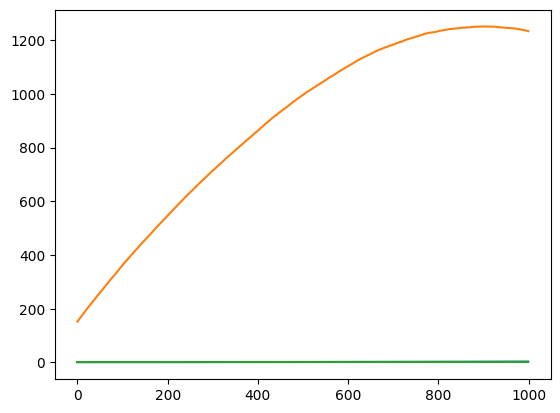

In [61]:
action=np.array([130,0])
enviorment.step(action)
A=[]
t=[]
enviorment.reset()

for i in range(1000):
    action, states = modelPPO.predict(enviorment.state)
    obs =enviorment.step(action)[0]
    A.append(obs)
    t.append(i)
plt.plot(t,A)

In [49]:
A[0]

1.0004725581941605

In [ ]:
ac